# GNN for Link + Vote Prediction with sliding window training

This notebook trains a **Hierarchical Graph Neural Network** to predict link existance and vote polarity simultaneously.

In this variant we explore the **sliding window training approach**, which consists in:

- firstly consider a window of fixed size W
- split the window in training, validation and test sets and perform training and evaluation
- then move the window by a step size S
- this approach until now **do not** use the concept of continual learning


## Setup

In [1]:
# Import standard libraries
import sys
from pathlib import Path
from collections import Counter
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Data handling
import pandas as pd
# Computations
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import LinkNeighborLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from dataset import WikiRfAPreprocessor, CandidateCentricSampler, train_val_test_split_by_date
from utility import sum_months, analyze_split_statistics

## Data loading and filtering

Load and parse the wiki-RfA dataset from the .txt.gz file into (SRC, TGT, VOT, DAT) tuples.

Invalid samples are filtered out:

- empty date
- incorrect date
- self votes

In [2]:
preprocessed_RfA = WikiRfAPreprocessor("dataset/wiki-RfA.txt.gz")
preprocessed_RfA.load(verbose=True)

Loading dataset from dataset/wiki-RfA.txt.gz...
Raw line 0: SRC:Steel1943
Raw line 1: TGT:BDD
Raw line 2: VOT:1
Raw line 3: RES:1
Raw line 4: YEA:2013
Raw line 5: DAT:23:13, 19 April 2013
Raw line 6: TXT:'''Support''' as co-nom.
Raw line 7: 
Raw line 8: SRC:Cuchullain
Raw line 9: TGT:BDD

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncycloped

## User encoding

Encode Wikipedia usernames into contiguous integer node IDs.

In [3]:
# Encode users as numerical IDs
users = list(set([s[0] for s in preprocessed_RfA.samples] + [s[1] for s in preprocessed_RfA.samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11128
[('wrp103', np.int64(11091)), ('TyA', np.int64(9957)), ('Eric Wester', np.int64(3144)), ('Petrb', np.int64(7428)), ('Barneyboo', np.int64(1017)), ('TMS63112', np.int64(9296)), ('Dan D. Ric', np.int64(2321)), ('Quiddity', np.int64(7755)), ('Hennessey, Patrick', np.int64(4181)), ('Mrmatiko', np.int64(6590))]


In [4]:
# Dataset build (edge list + label)
X = []
y = []
dates = []

for src, tgt, vot, dat in preprocessed_RfA.samples:
    X.append([user_map[src], user_map[tgt]])
    y.append(vot)
    dates.append(dat)
        
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)
dates = np.array(dates)

# labels for positives: {-1,0,1} -> {1,2,3}
y_pos = y + 2
print("Positive edges:", X.size(0))

Positive edges: 188816


## Generate windows

In [12]:
def get_windows(X: torch.Tensor, y: torch.Tensor, dates: np.ndarray, window_size_months=36, step_size_months=6, val_months=6, test_months=6):
    """
    Generate time-based train/val/test splits for each window.
    Args:
        X (torch.Tensor): Edge list tensor of shape (num_edges, 2).
        y (torch.Tensor): Labels tensor of shape (num_edges,).
        dates (np.ndarray): Array of dates corresponding to each edge.
        window_size_months (int): Size of each time window in months.
        step_size_months (int): Step size to move the window in months.
        val_months (int): Number of months for the validation set.
        test_months (int): Number of months for the test set.
    Yields:
        Tuples of (X_train, y_train, dates_train, X_val, y_val, dates_val, X_test, y_test, dates_test) for each time window.
    """
    current_start = min(dates)

    while True:
        current_end = sum_months(current_start, window_size_months)
        
        if current_end > max(dates):
            print("Reached the end of the date range. Discarded window:", current_start, "->", current_end)
            break
        
        # Extract the window
        mask_window = (dates >= current_start) & (dates < current_end)
        # If the window is empty, skip it
        if not np.any(mask_window):
            current_start = sum_months(current_start, step_size_months)
            continue

        # Internal splitting
        yield train_val_test_split_by_date(
            X[mask_window],
            y[mask_window],
            dates[mask_window],
            val_months=val_months,
            test_months=test_months
        )
        
        # Go to the next window
        current_start = sum_months(current_start, step_size_months)

windows = get_windows(X, y_pos, dates)

Reached the end of the date range. Discarded window: 20100816 -> 20130816
    Total_Size        Train_Interval          Val_Interval         Test_Interval
0        52168  (20030816, 20050814)  (20050815, 20060214)  (20060215, 20060815)
1        71369  (20040216, 20060214)  (20060215, 20060814)  (20060815, 20070215)
2        88760  (20040816, 20060814)  (20060815, 20070214)  (20070215, 20070815)
3       106034  (20050216, 20070214)  (20070215, 20070814)  (20070815, 20080215)
4       117673  (20050816, 20070814)  (20070815, 20080214)  (20080215, 20080815)
5       110467  (20060216, 20080214)  (20080215, 20080814)  (20080815, 20090215)
6        96891  (20060816, 20080814)  (20080815, 20090214)  (20090215, 20090815)
7        87371  (20070216, 20090214)  (20090215, 20090814)  (20090815, 20100215)
8        74046  (20070816, 20090814)  (20090815, 20100214)  (20100215, 20100815)
9        60723  (20080216, 20100214)  (20100215, 20100814)  (20100815, 20110215)
10       49709  (20080816, 20100814

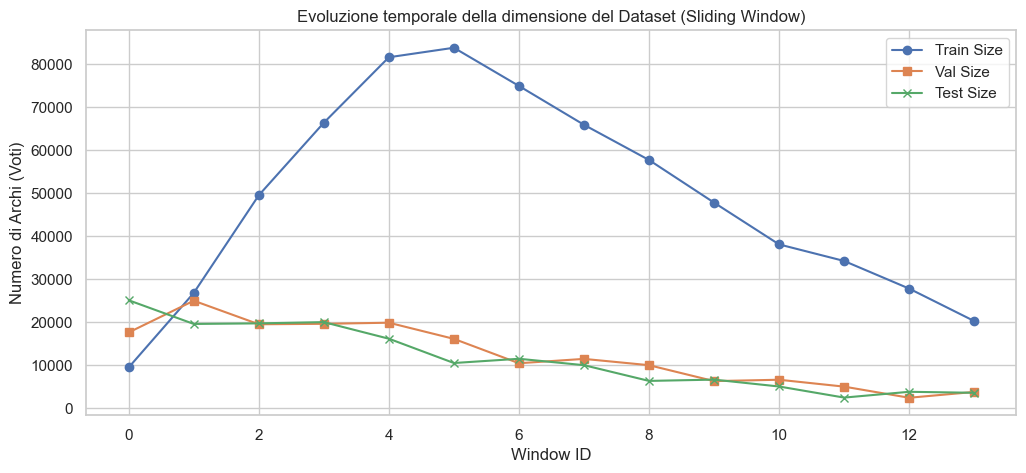

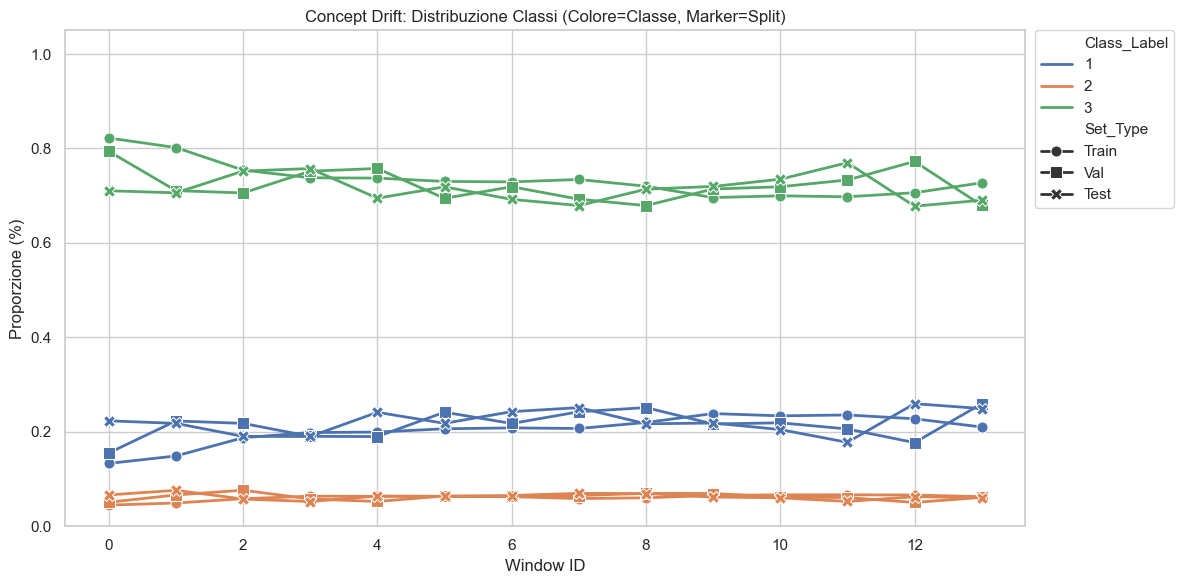

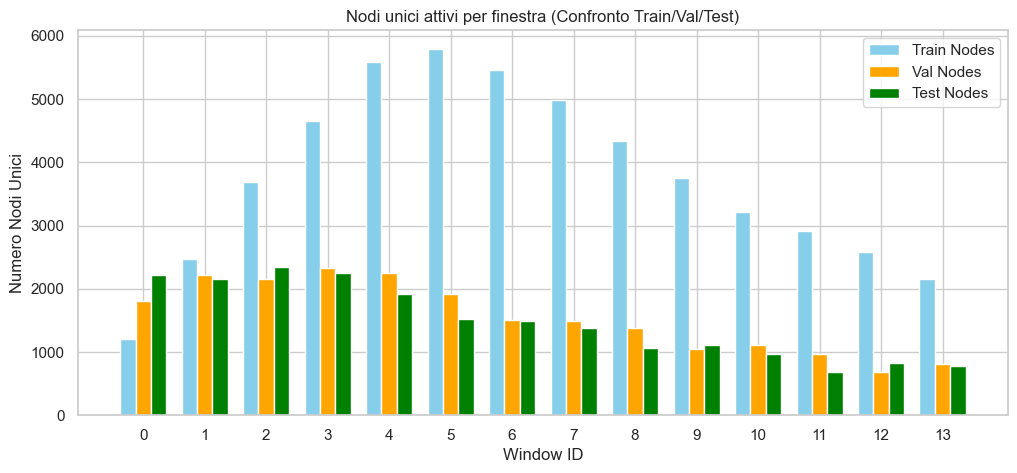

In [14]:
def analyze_sliding_windows(window_generator):
    """
    Consuma il generatore di finestre e calcola statistiche dettagliate.
    Args:
        window_generator: Il generatore restituito da get_windows()
    Returns:
        pd.DataFrame: DataFrame contenente le statistiche per ogni finestra.
    """
    stats_list = []
    
    for i, ((X_tr, y_tr, dates_tr), (X_va, y_va, dates_va), (X_te, y_te, dates_te)) in enumerate(window_generator):
        
        # Calcolo distribuzioni delle classi
        train_counts = Counter(y_tr.numpy())
        val_counts = Counter(y_va.numpy())
        test_counts = Counter(y_te.numpy())
        
        # Calcolo nodi unici attivi (Voters + Candidates)
        train_unique_nodes = len(np.unique(X_tr.numpy()))
        val_unique_nodes = len(np.unique(X_va.numpy()))
        test_unique_nodes = len(np.unique(X_te.numpy()))
        
        # Struttura dati per il DataFrame
        row = {
            'Window_ID': i,
            'Train_Size': len(y_tr),
            'Val_Size': len(y_va),
            'Test_Size': len(y_te),
            'Total_Size': len(y_tr) + len(y_va) + len(y_te),
            'Train_Interval': (min(dates_tr), max(dates_tr)),
            'Val_Interval': (min(dates_va), max(dates_va)),
            'Test_Interval': (min(dates_te), max(dates_te)),
            'Train_Unique_Nodes': train_unique_nodes,
            'Val_Unique_Nodes': val_unique_nodes,
            'Test_Unique_Nodes': test_unique_nodes,
            'Train_Ratio': len(y_tr) / (len(y_tr) +len(y_va) + len(y_te)),
            'Val_Ratio': len(y_va) / (len(y_tr) + len(y_va) + len(y_te)),
            'Test_Ratio': len(y_te) / (len(y_tr) + len(y_va) + len(y_te))
        }
        
        # Aggiungiamo le info sulle classi in colonne separate (es. Train_Class_0, Train_Class_1...)
        all_classes = set(list(train_counts.keys()) + list(val_counts.keys()) + list(test_counts.keys()))
        for cls in sorted(all_classes):
            row[f'Train_Class_{cls}'] = train_counts.get(cls, 0)
            row[f'Val_Class_{cls}'] = val_counts.get(cls, 0)
            row[f'Test_Class_{cls}'] = test_counts.get(cls, 0)
            
            # Calcoliamo anche la percentuale per vedere il drift
            row[f'Train_Perc_Class_{cls}'] = train_counts.get(cls, 0) / len(y_tr) if len(y_tr) > 0 else 0
            row[f'Val_Perc_Class_{cls}'] = val_counts.get(cls, 0) / len(y_va) if len(y_va) > 0 else 0
            row[f'Test_Perc_Class_{cls}'] = test_counts.get(cls, 0) / len(y_te) if len(y_te) > 0 else 0
            
        stats_list.append(row)

    df_stats = pd.DataFrame(stats_list)
    return df_stats

def plot_window_stats(df_stats):
    sns.set_theme(style="whitegrid")
    
    # --- 1. Plot Dimensione dei Dataset nel tempo ---
    plt.figure(figsize=(12, 5))
    plt.plot(df_stats['Window_ID'], df_stats['Train_Size'], label='Train Size', marker='o')
    plt.plot(df_stats['Window_ID'], df_stats['Val_Size'], label='Val Size', marker='s')
    plt.plot(df_stats['Window_ID'], df_stats['Test_Size'], label='Test Size', marker='x')
    plt.title('Evoluzione temporale della dimensione del Dataset (Sliding Window)')
    plt.xlabel('Window ID')
    plt.ylabel('Numero di Archi (Voti)')
    plt.legend()
    plt.show()
    
    # --- 2. Plot Distribuzione delle Classi (Concept Drift) ---
    perc_cols = [c for c in df_stats.columns if '_Perc_Class_' in c]
    
    if perc_cols:
        df_melted = df_stats.melt(id_vars='Window_ID', value_vars=perc_cols, 
                                  var_name='Variable', value_name='Percentage')
        
        # Funzione per estrarre Set e Classe dal nome della colonna
        def parse_col_name(name):
            parts = name.split('_Perc_Class_')
            return parts[0], parts[1]

        df_melted[['Set_Type', 'Class_Label']] = df_melted['Variable'].apply(
            lambda x: pd.Series(parse_col_name(x))
        )
        
        plt.figure(figsize=(12, 6))
        
        markers_map = {"Train": "o", "Val": "s", "Test": "X"}
        linestyles_map = {"Train": "", "Val": "", "Test": ""}         
        sns.lineplot(
            data=df_melted, 
            x='Window_ID', 
            y='Percentage', 
            hue='Class_Label',    # Stesso colore per la stessa classe
            style='Set_Type',     # Diverso simbolo per Train/Val/Test
            markers=markers_map,  # Mappatura personalizzata dei simboli
            dashes=False,         # Forza linee solide per tutti (la distinzione è nel marker)
            linewidth=2,
            markersize=8
        )
        plt.title('Concept Drift: Distribuzione Classi (Colore=Classe, Marker=Split)')
        plt.xlabel('Window ID')
        plt.ylabel('Proporzione (%)')
        plt.ylim(0, 1.05)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()
    
    # --- 3. Analisi Nodi Unici (Densità/Sparsità) ---
    plt.figure(figsize=(12, 5))
    bar_width = 0.25
    x = df_stats['Window_ID']
    plt.bar(x - bar_width, df_stats['Train_Unique_Nodes'], width=bar_width, label='Train Nodes', color='skyblue')
    plt.bar(x, df_stats['Val_Unique_Nodes'], width=bar_width, label='Val Nodes', color='orange')
    plt.bar(x + bar_width, df_stats['Test_Unique_Nodes'], width=bar_width, label='Test Nodes', color='green')
    plt.title('Nodi unici attivi per finestra (Confronto Train/Val/Test)')
    plt.xlabel('Window ID')
    plt.ylabel('Numero Nodi Unici')
    plt.xticks(x) # Assicura che ci sia un tick per ogni finestra
    plt.legend()
    plt.show()

# --- ESEMPIO DI UTILIZZO ---
# Nota: Ricrea il generatore perché i generatori si esauriscono una volta iterati!
windows_gen = get_windows(X, y_pos, dates)

df_results = analyze_sliding_windows(windows_gen)
pd.set_option('display.width', 100)
print(df_results[["Total_Size", "Train_Interval", "Val_Interval", "Test_Interval"]])
plot_window_stats(df_results)

## Node features extraction

In [15]:
def extract_node_features(edge_index, edge_dates_int, num_nodes):
    """
    Calcola features strutturali e temporali per i nodi in un grafo dinamico.
    
    Args:
        edge_index (Tensor): [2, E] Source (Voter) -> Target (Candidate)
        edge_dates_int (Tensor/Array): [E] Date in formato YYYYMMDD (int)
        num_nodes (int): Numero totale di nodi nel grafo
    Returns:
        torch.Tensor: [num_nodes, 6] Feature matrix normalizzata
    """
    
    # Conversion: YYYYMMDD to Timestamp Linear (days)
    dates_pd = pd.to_datetime(edge_dates_int, format='%Y%m%d')
    ref_date = pd.to_datetime(edge_dates_int.max(), format='%Y%m%d')
    
    df = pd.DataFrame({
        'src': edge_index[0].cpu().numpy(),
        'tgt': edge_index[1].cpu().numpy(),
        'date': dates_pd
    })
    
    # Initialize features to 0 ----> [In-Deg, Out-Deg, Tenure, Recency, Span, Freq]
    features = np.zeros((num_nodes, 6), dtype=np.float32)
    
    # ---------------------------------------------------------
    # 1. Structural Features (Degrees)
    # ---------------------------------------------------------
    in_degree = df.groupby('tgt').size()
    out_degree = df.groupby('src').size()
    
    features[in_degree.index, 0] = in_degree.values  # In-Degree (Votes Received)
    features[out_degree.index, 1] = out_degree.values # Out-Degree (Votes Given)

    # ---------------------------------------------------------
    # 2. Temporal Features (Tenure, Recency, Span)
    # ---------------------------------------------------------
    # Group by SRC (Voter) to calculate T_first_vote and T_last_vote
    grp_src = df.groupby('src')['date'].agg(['min', 'max'])
    
    voter_indices = grp_src.index.values
    t_first = grp_src['min']
    t_last = grp_src['max']
    
    # (.dt.days converts Timedelta to int)
    features[voter_indices, 2] = (ref_date - t_first).dt.days.values   # Tenure (Anzianità): T_now - T_first
    features[voter_indices, 3] = (ref_date - t_last).dt.days.values    # Recency (Recenza): T_now - T_last
    features[voter_indices, 4] = (t_last - t_first).dt.days.values     # Activity Span: T_last - T_first
    
    # ---------------------------------------------------------
    # 3. Derived Features (Frequency)
    # ---------------------------------------------------------
    # Add 1 day to span to avoid division by zero     
    safe_span = features[voter_indices, 4] + 1.0 
    votes_given = features[voter_indices, 1]
    
    features[voter_indices, 5] = votes_given / safe_span

    # ---------------------------------------------------------
    # 4. Normalizzazione Logaritmica (Critica per Neural Networks)
    # ---------------------------------------------------------   
    return torch.tensor(np.log1p(features), dtype=torch.float)

## Model

In [16]:
class HierGNN(nn.Module):
    def __init__(self, feature_dim, emb_dim=64, hidden_dim=128, dropout=0.3):
        super().__init__()

        # # Learnable node ID embeddings (replaces one-hot)
        # self.node_emb = nn.Embedding(num_nodes, emb_dim)

        # Sostituiamo Embedding con un Linear layer per proiettare le feature
        self.node_emb = nn.Linear(feature_dim, emb_dim)

        # GraphSAGE encoder (2 message-passing layers)
        self.conv1 = SAGEConv(emb_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = dropout

        # Edge feature dimension: [h_s, h_t, |h_s-h_t|, h_s*h_t]
        edge_in = hidden_dim * 4

        # Head 1: link existence (NoVote vs Voted)
        self.link_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

        # Head 2: polarity (Oppose/Neutral/Support)
        self.pol_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 3)
        )

    def encode(self, batch):
        # Compute node embeddings on the sampled subgraph returned by LinkNeighborLoader
        x = self.node_emb(batch.x)

        x = self.conv1(x, batch.edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, batch.edge_index)
        x = F.relu(x)
        return x

    def edge_features(self, z, edge_label_index):
        # Build edge features from endpoint embeddings
        src, tgt = edge_label_index
        h_src, h_tgt = z[src], z[tgt]
        return torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)

    def forward(self, batch: Data):
        """
        Forward pass that returns both heads' logits for the batch edge_label_index.
        - link_logits: shape [B, 2]
        - pol_logits: shape [B, 3]
        """
        z = self.encode(batch)
        e = self.edge_features(z, batch.edge_label_index)
        link_logits = self.link_mlp(e)
        pol_logits  = self.pol_mlp(e)
        return link_logits, pol_logits

## Training loop

In [17]:
def eval_hierarchical(model, loader, device, report=False):
    """
    Evaluate on a loader built over the 4-class dataset (pos+neg edges).
    We compute:
      - link prediction: NoVote vs Voted (binary)
      - final 4-class prediction: NoVote or (polarity+1) when predicted Voted
      - polarity on true-positive edges where the model also predicts Voted
    """
    model.eval()
    y_true_all, y_pred4_all, y_true_link_all, y_pred_link_all = [], [], [], []
    y_true_pol_tp, y_pred_pol_tp = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            link_logits, pol_logits = model(batch)

            # True labels
            y_true_4 = batch.edge_label  # {0,1,2,3}
            y_true_link = (y_true_4 != 0).long()

            # Predictions
            link_pred = link_logits.argmax(dim=1)            # {0,1}
            pol_pred  = pol_logits.argmax(dim=1)             # {0,1,2}

            # Final 4-class: if predicted NoVote -> 0 else (pol_pred+1)
            y_pred_4 = torch.zeros_like(y_true_4)
            voted_mask_pred = (link_pred == 1)
            y_pred_4[voted_mask_pred] = pol_pred[voted_mask_pred] + 1

            # Store global metrics
            y_true_all.append(y_true_4.cpu())
            y_pred4_all.append(y_pred_4.cpu())
            y_true_link_all.append(y_true_link.cpu())
            y_pred_link_all.append(link_pred.cpu())

            # Polarity on true-positive edges where the model also predicts Voted
            tp_mask = (y_true_link == 1) & (link_pred == 1)
            if tp_mask.any():
                y_true_pol_tp.append((y_true_4[tp_mask] - 1).cpu())  # {0,1,2}
                y_pred_pol_tp.append(pol_pred[tp_mask].cpu())

    y_true_4 = torch.cat(y_true_all).numpy()
    y_pred_4 = torch.cat(y_pred4_all).numpy()
    y_true_link = torch.cat(y_true_link_all).numpy()
    y_pred_link = torch.cat(y_pred_link_all).numpy()

    macro_f1_4 = f1_score(y_true_4, y_pred_4, average="macro")
    link_f1 = f1_score(y_true_link, y_pred_link, average="binary")

    pol_report = None
    if len(y_true_pol_tp) > 0:
        y_true_pol = torch.cat(y_true_pol_tp).numpy()
        y_pred_pol = torch.cat(y_pred_pol_tp).numpy()
        pol_macro_f1 = f1_score(y_true_pol, y_pred_pol, average="macro")
        if report:
            pol_report = classification_report(
                y_true_pol, y_pred_pol,
                target_names=["Oppose", "Neutral", "Support"],
                digits=2
            )
    else:
        pol_macro_f1 = float("nan")

    return macro_f1_4, link_f1, pol_macro_f1, (y_true_4, y_pred_4), pol_report

In [18]:
def training_loop(model, optimizer, train_loader, val_loader, device, link_weights, pol_weights, patience = 5, lambda_pol = 1.0, num_epochs=50):
    best_f1 = -1.0
    best_state = None
    bad_epochs = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_ex = 0.0 ,0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            link_logits, pol_logits = model(batch)

            y_true_4 = batch.edge_label                # {0,1,2,3}
            y_true_link = (y_true_4 != 0).long()       # {0,1}

            # 1) Link loss on all edges in the batch
            loss_link = F.cross_entropy(link_logits, y_true_link, weight=link_weights)

            # 2) Polarity loss only on positive (voted) edges
            pos_mask = (y_true_link == 1)
            if pos_mask.any():
                y_true_pol = (y_true_4[pos_mask] - 1).long()  # {0,1,2}
                loss_pol = F.cross_entropy(pol_logits[pos_mask], y_true_pol, weight=pol_weights)
            else:
                loss_pol = torch.tensor(0.0, device=device)

            loss = loss_link + lambda_pol * loss_pol
            loss.backward()
            optimizer.step()

            bs = y_true_4.size(0)
            total_loss += loss.item() * bs
            total_ex += bs

        train_loss = total_loss / total_ex

        # Validation (hierarchical 4-class + link)
        val_macro_f1_4, val_link_f1, val_pol_f1, _, _ = eval_hierarchical(model, val_loader, device, report=False)
        print(f"Epoch {epoch:02d} | Loss(avg): {train_loss:.4f} | Val macro-F1(4): {val_macro_f1_4:.4f} | Val link-F1: {val_link_f1:.4f} | Val pol-macroF1: {val_pol_f1:.4f}")

        if val_macro_f1_4 > best_f1 + 1e-4:
            best_f1 = val_macro_f1_4
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping. Best Val macro-F1(4): {best_f1:.4f}")
                break
    
    return best_state


--- Window 0 ---

===================== DATASET SPLITTING ANALYSIS =====================

[1] Topology & Density (Graph Connectivity)
       Edges  Nodes Avg Degree
Split                         
Train   9173   1201       7.64
Val    17144   1811       9.47
Test   24308   2222      10.94

[2] User Overlap & Cold Start Diagnostics (Inductive vs Transductive)


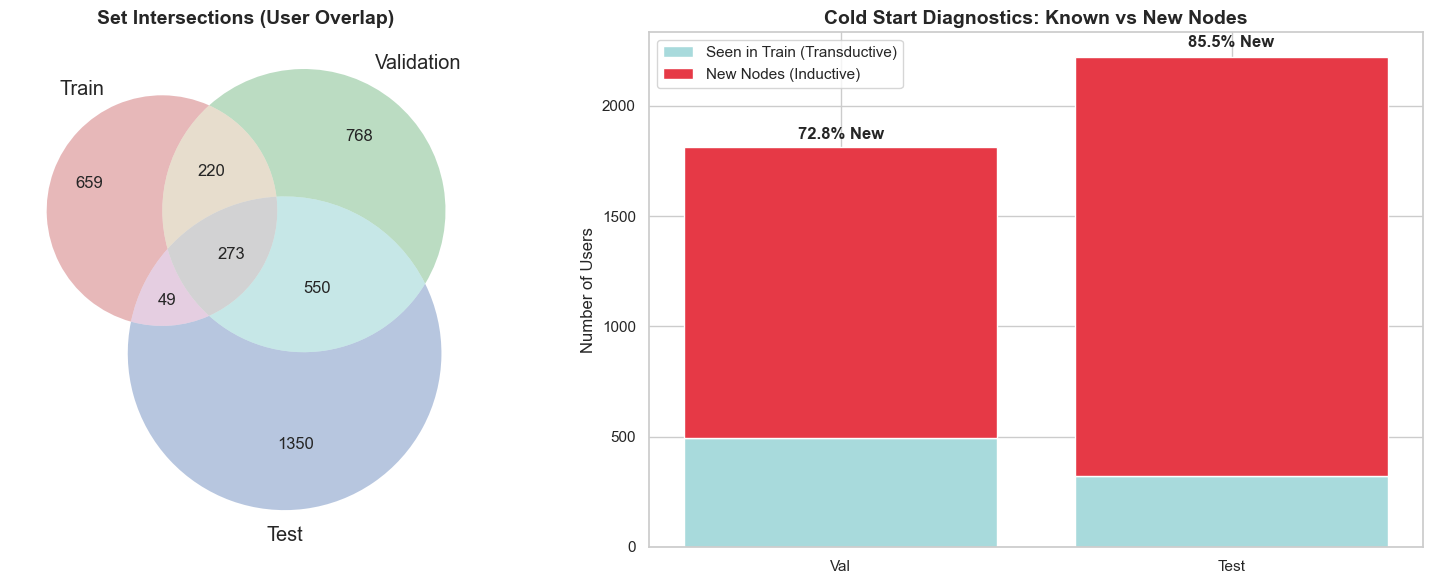


[3] Edge Duplicates Analysis
Found 77 duplicate edges between Train-Val
Found 9 duplicate edges between Train-Test
Found 355 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


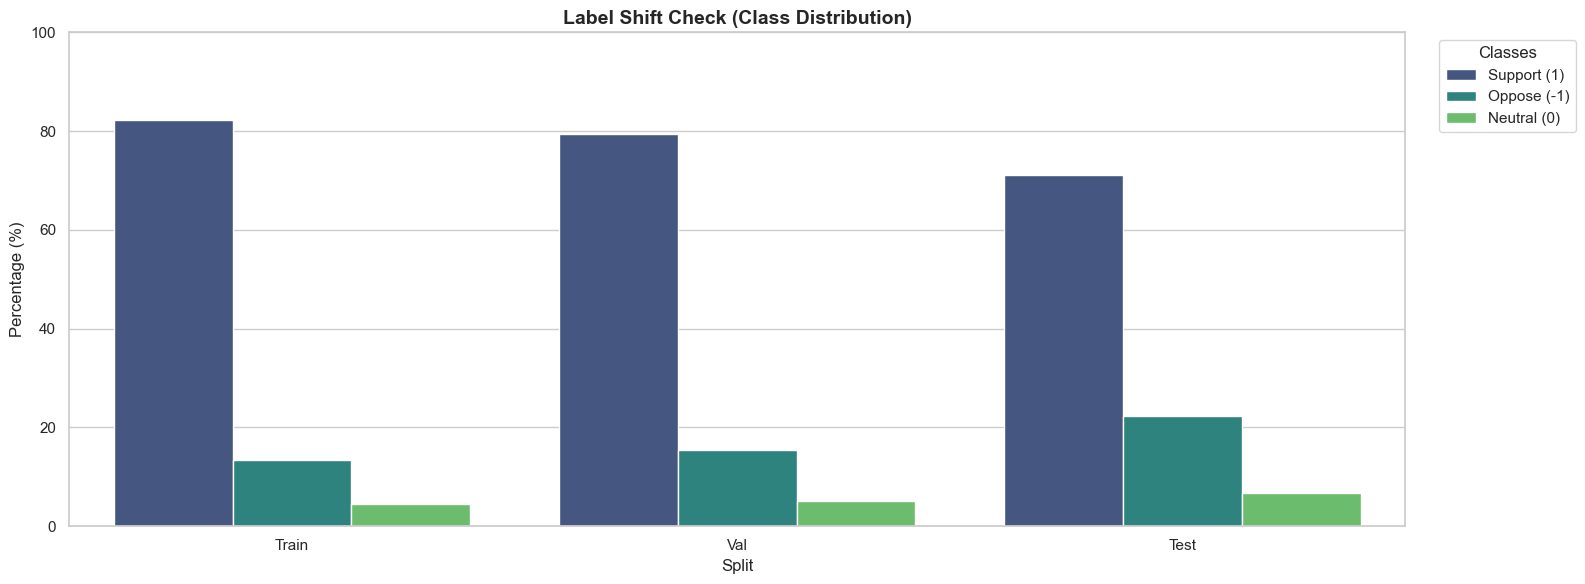

Epoch 00 | Loss(avg): 1.2709 | Val macro-F1(4): 0.2766 | Val link-F1: 0.3237 | Val pol-macroF1: 0.2941
Epoch 01 | Loss(avg): 1.0637 | Val macro-F1(4): 0.3012 | Val link-F1: 0.4216 | Val pol-macroF1: 0.2941
Epoch 02 | Loss(avg): 1.0360 | Val macro-F1(4): 0.3021 | Val link-F1: 0.4252 | Val pol-macroF1: 0.2944
Epoch 03 | Loss(avg): 1.0287 | Val macro-F1(4): 0.3018 | Val link-F1: 0.4220 | Val pol-macroF1: 0.2945
Epoch 04 | Loss(avg): 1.0243 | Val macro-F1(4): 0.3022 | Val link-F1: 0.4236 | Val pol-macroF1: 0.2946
Epoch 05 | Loss(avg): 1.0123 | Val macro-F1(4): 0.3030 | Val link-F1: 0.4286 | Val pol-macroF1: 0.2946
Epoch 06 | Loss(avg): 1.0051 | Val macro-F1(4): 0.3016 | Val link-F1: 0.4187 | Val pol-macroF1: 0.2945
Epoch 07 | Loss(avg): 0.9937 | Val macro-F1(4): 0.3047 | Val link-F1: 0.4230 | Val pol-macroF1: 0.2946
Epoch 08 | Loss(avg): 0.9832 | Val macro-F1(4): 0.3057 | Val link-F1: 0.4230 | Val pol-macroF1: 0.2964
Epoch 09 | Loss(avg): 0.9692 | Val macro-F1(4): 0.3049 | Val link-F1: 0.4

c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.2470
Test link-F1 (existence): 0.1732
Test polarity macro-F1 on TP edges: 0.3490

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.68      0.97      0.80     50186
      Oppose       0.16      0.03      0.05      5602
     Neutral       0.00      0.00      0.00      1664
     Support       0.50      0.08      0.13     17827

    accuracy                           0.67     75279
   macro avg       0.34      0.27      0.25     75279
weighted avg       0.59      0.67      0.57     75279


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.31      0.29      0.30       579
     Neutral       0.00      0.00      0.00       199
     Support       0.70      0.79      0.74      1725

    accuracy                           0.62      2503
   macro avg       0.34      0.36      0.35      

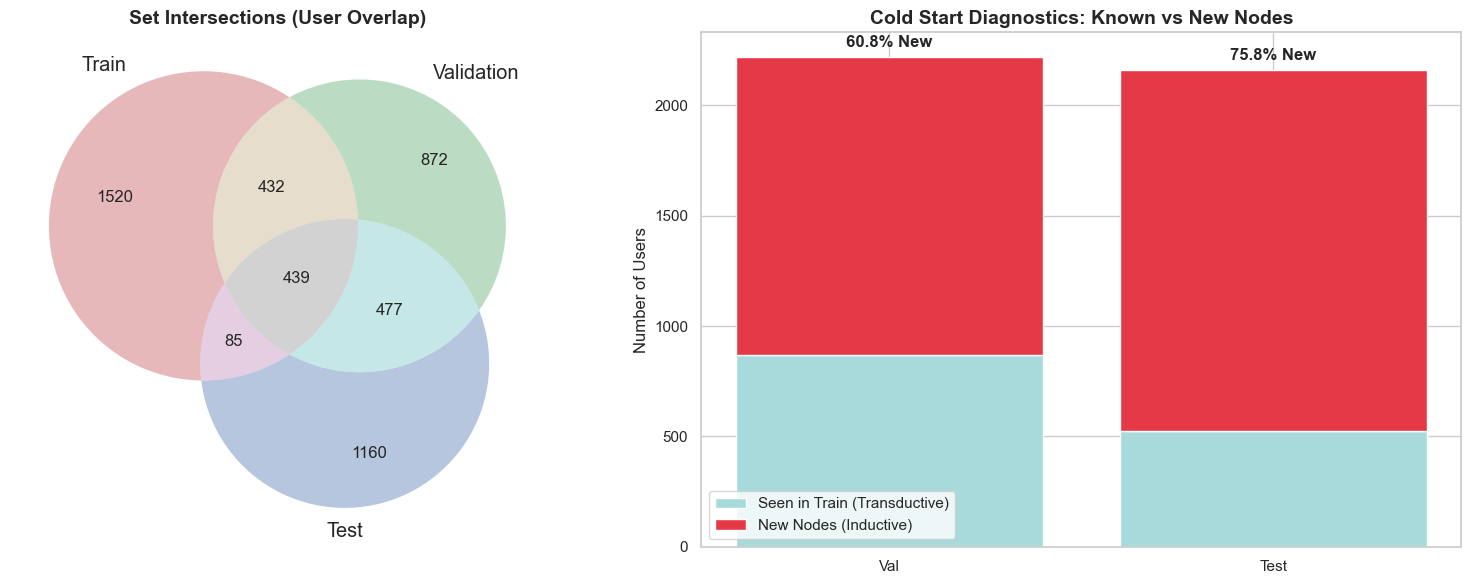


[3] Edge Duplicates Analysis
Found 364 duplicate edges between Train-Val
Found 16 duplicate edges between Train-Test
Found 363 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


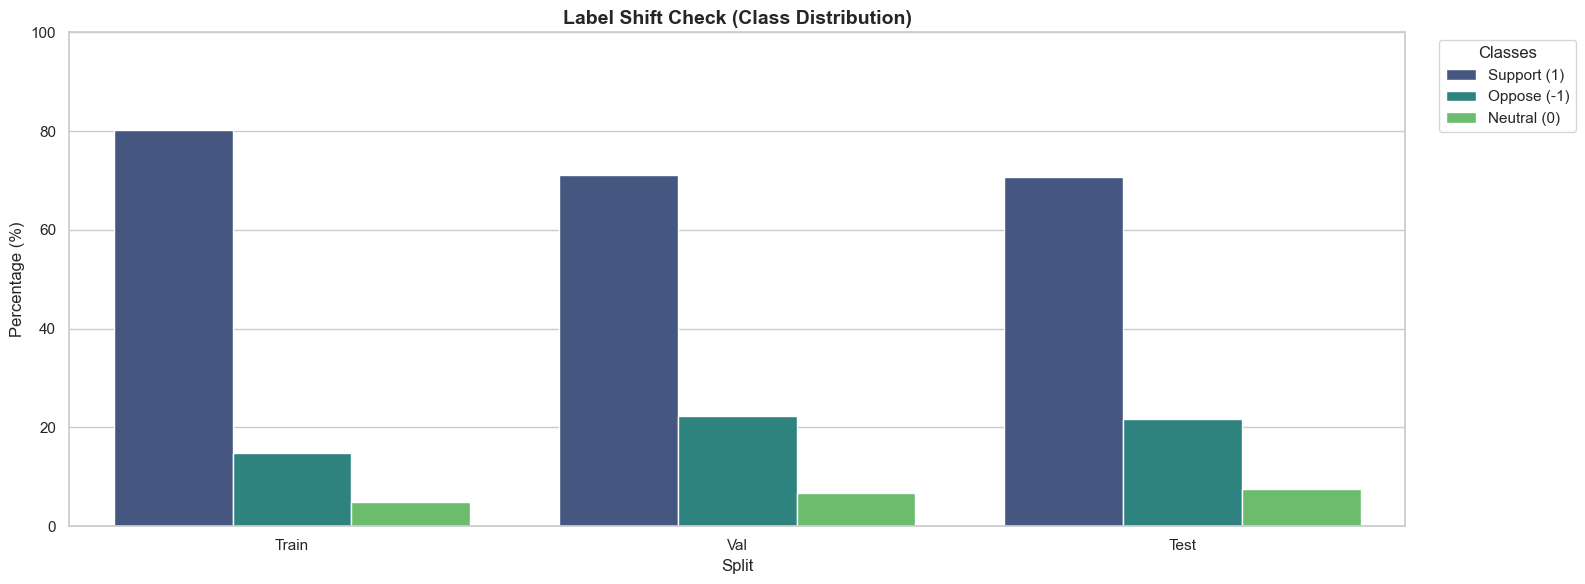

Epoch 00 | Loss(avg): 1.0707 | Val macro-F1(4): 0.3690 | Val link-F1: 0.5657 | Val pol-macroF1: 0.3656
Epoch 01 | Loss(avg): 1.0339 | Val macro-F1(4): 0.3610 | Val link-F1: 0.5816 | Val pol-macroF1: 0.3358
Epoch 02 | Loss(avg): 1.0180 | Val macro-F1(4): 0.3463 | Val link-F1: 0.5629 | Val pol-macroF1: 0.3110
Epoch 03 | Loss(avg): 1.0063 | Val macro-F1(4): 0.3443 | Val link-F1: 0.5639 | Val pol-macroF1: 0.3053
Epoch 04 | Loss(avg): 0.9922 | Val macro-F1(4): 0.3333 | Val link-F1: 0.5586 | Val pol-macroF1: 0.2813
Epoch 05 | Loss(avg): 0.9881 | Val macro-F1(4): 0.3333 | Val link-F1: 0.5554 | Val pol-macroF1: 0.2834
Early stopping. Best Val macro-F1(4): 0.3690


c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.2597
Test link-F1 (existence): 0.2851
Test polarity macro-F1 on TP edges: 0.2426

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.70      0.95      0.81     39160
      Oppose       0.15      0.14      0.15      4265
     Neutral       0.00      0.00      0.00      1490
     Support       0.47      0.05      0.09     13825

    accuracy                           0.66     58740
   macro avg       0.33      0.29      0.26     58740
weighted avg       0.59      0.66      0.57     58740


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.22      0.81      0.35       751
     Neutral       0.00      0.00      0.00       187
     Support       0.79      0.25      0.38      2629

    accuracy                           0.35      3567
   macro avg       0.34      0.35      0.24      

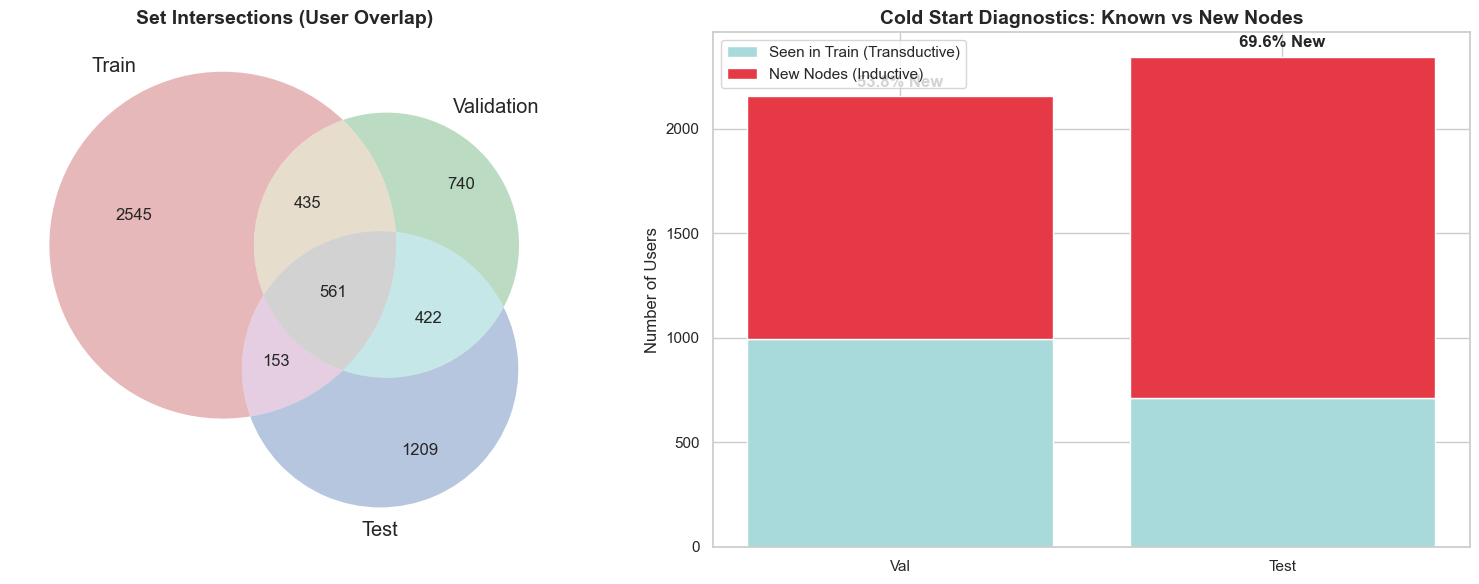


[3] Edge Duplicates Analysis
Found 376 duplicate edges between Train-Val
Found 50 duplicate edges between Train-Test
Found 333 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


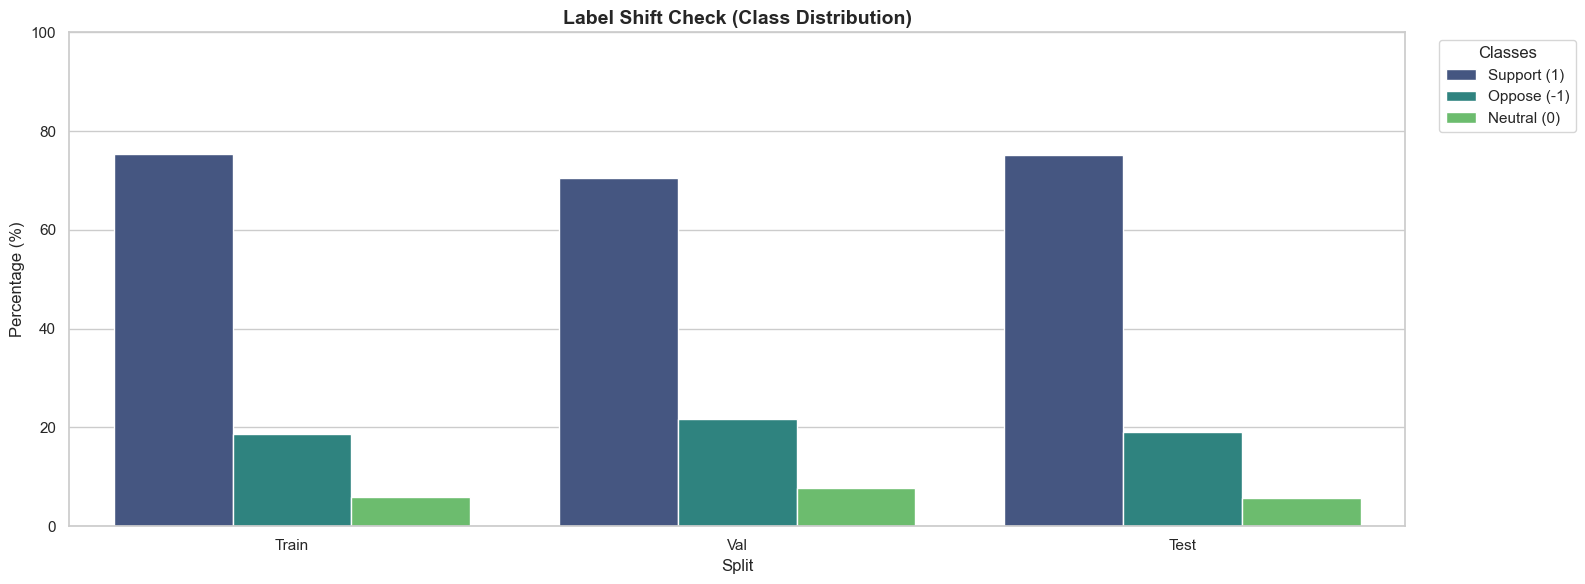

Epoch 00 | Loss(avg): 1.0987 | Val macro-F1(4): 0.3698 | Val link-F1: 0.6068 | Val pol-macroF1: 0.3375
Epoch 01 | Loss(avg): 1.0721 | Val macro-F1(4): 0.3587 | Val link-F1: 0.6098 | Val pol-macroF1: 0.3118
Epoch 02 | Loss(avg): 1.0441 | Val macro-F1(4): 0.3595 | Val link-F1: 0.6044 | Val pol-macroF1: 0.3159
Epoch 03 | Loss(avg): 1.0361 | Val macro-F1(4): 0.3573 | Val link-F1: 0.6169 | Val pol-macroF1: 0.3043
Epoch 04 | Loss(avg): 1.0279 | Val macro-F1(4): 0.3374 | Val link-F1: 0.5875 | Val pol-macroF1: 0.2748
Epoch 05 | Loss(avg): 1.0163 | Val macro-F1(4): 0.3450 | Val link-F1: 0.5915 | Val pol-macroF1: 0.2898
Early stopping. Best Val macro-F1(4): 0.3698


c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.2601
Test link-F1 (existence): 0.3029
Test polarity macro-F1 on TP edges: 0.2146

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.70      0.95      0.81     39432
      Oppose       0.15      0.19      0.17      3753
     Neutral       0.00      0.00      0.00      1135
     Support       0.46      0.03      0.06     14828

    accuracy                           0.65     59148
   macro avg       0.33      0.29      0.26     59148
weighted avg       0.59      0.65      0.57     59148


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.22      0.86      0.35       829
     Neutral       0.00      0.00      0.00       181
     Support       0.79      0.18      0.29      2861

    accuracy                           0.32      3871
   macro avg       0.34      0.35      0.21      

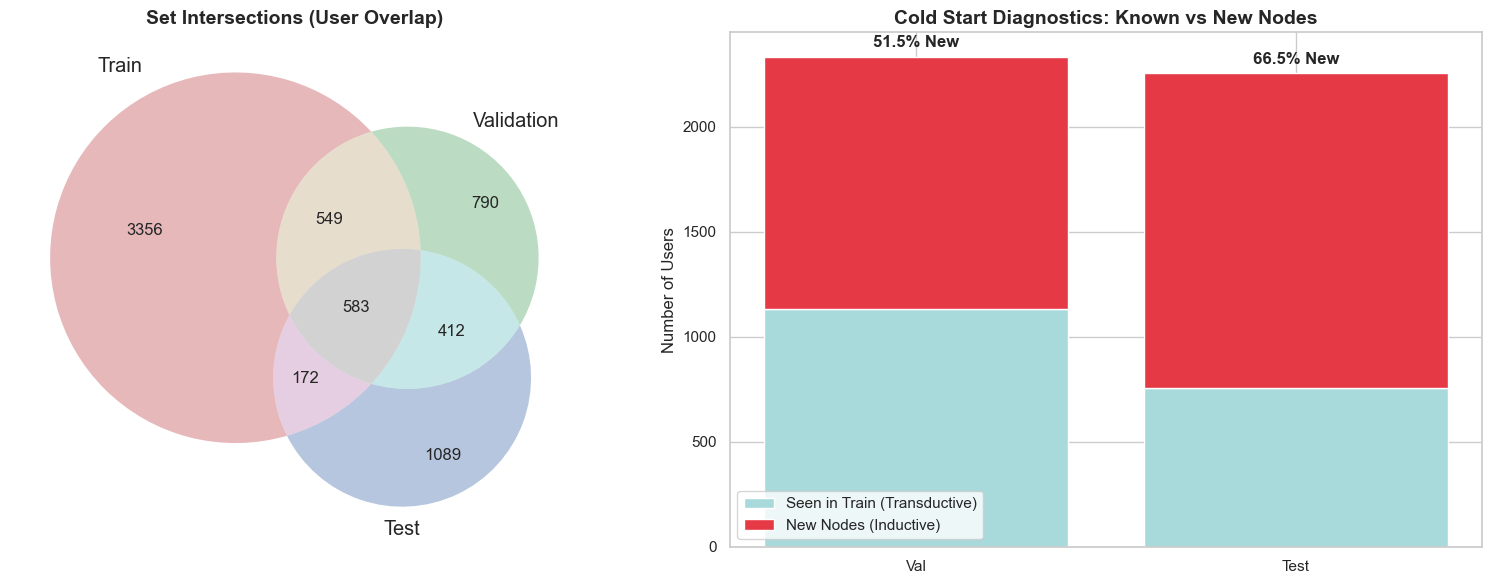


[3] Edge Duplicates Analysis
Found 373 duplicate edges between Train-Val
Found 84 duplicate edges between Train-Test
Found 470 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


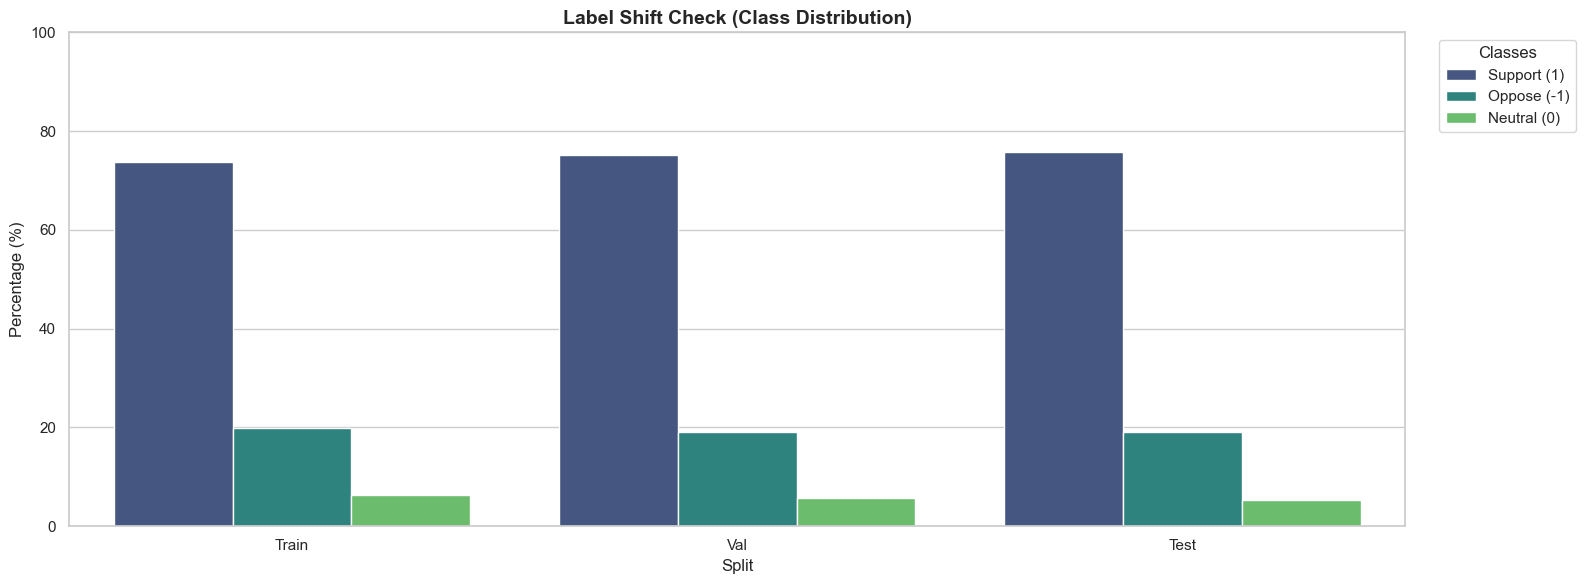

Epoch 00 | Loss(avg): 1.1056 | Val macro-F1(4): 0.3405 | Val link-F1: 0.5709 | Val pol-macroF1: 0.2970
Epoch 01 | Loss(avg): 1.0824 | Val macro-F1(4): 0.3601 | Val link-F1: 0.5702 | Val pol-macroF1: 0.3401
Epoch 02 | Loss(avg): 1.0657 | Val macro-F1(4): 0.3502 | Val link-F1: 0.5527 | Val pol-macroF1: 0.3242
Epoch 03 | Loss(avg): 1.0544 | Val macro-F1(4): 0.3570 | Val link-F1: 0.5613 | Val pol-macroF1: 0.3379
Epoch 04 | Loss(avg): 1.0425 | Val macro-F1(4): 0.3412 | Val link-F1: 0.5499 | Val pol-macroF1: 0.3058
Epoch 05 | Loss(avg): 1.0357 | Val macro-F1(4): 0.3424 | Val link-F1: 0.5509 | Val pol-macroF1: 0.3082
Epoch 06 | Loss(avg): 1.0228 | Val macro-F1(4): 0.3506 | Val link-F1: 0.5655 | Val pol-macroF1: 0.3214
Early stopping. Best Val macro-F1(4): 0.3601
Test macro-F1(4-class): 0.2643
Test link-F1 (existence): 0.3330
Test polarity macro-F1 on TP edges: 0.2312

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      No

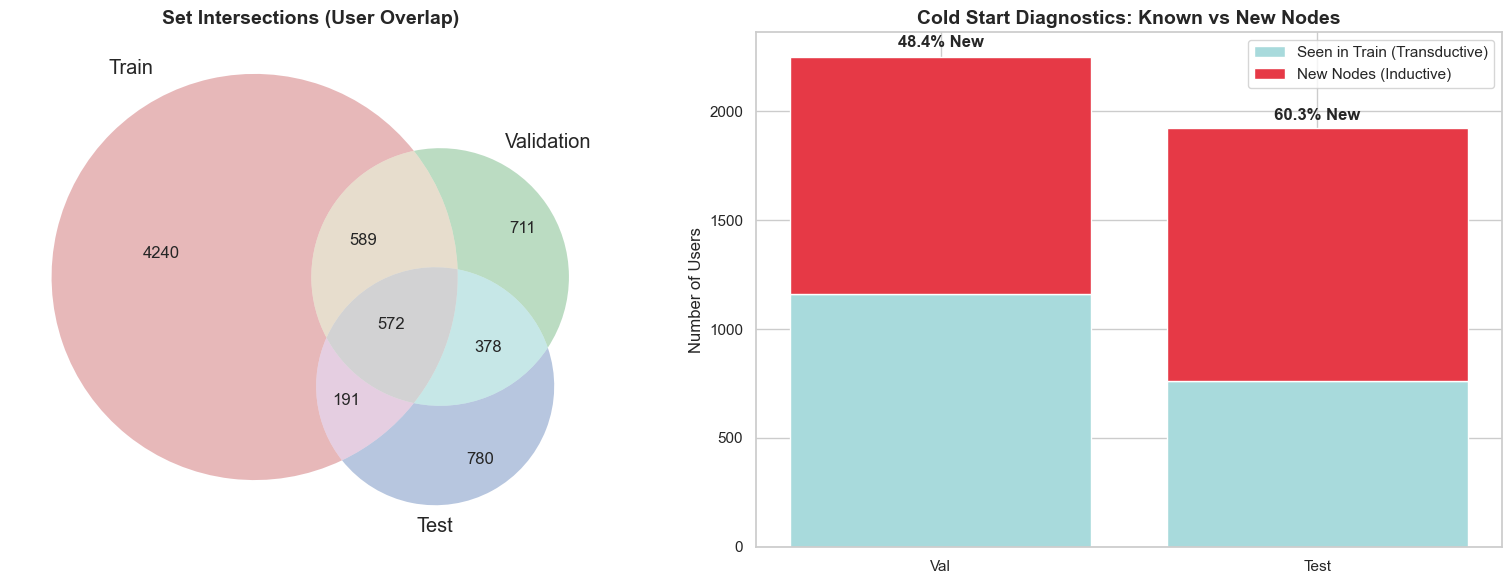


[3] Edge Duplicates Analysis
Found 527 duplicate edges between Train-Val
Found 153 duplicate edges between Train-Test
Found 478 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


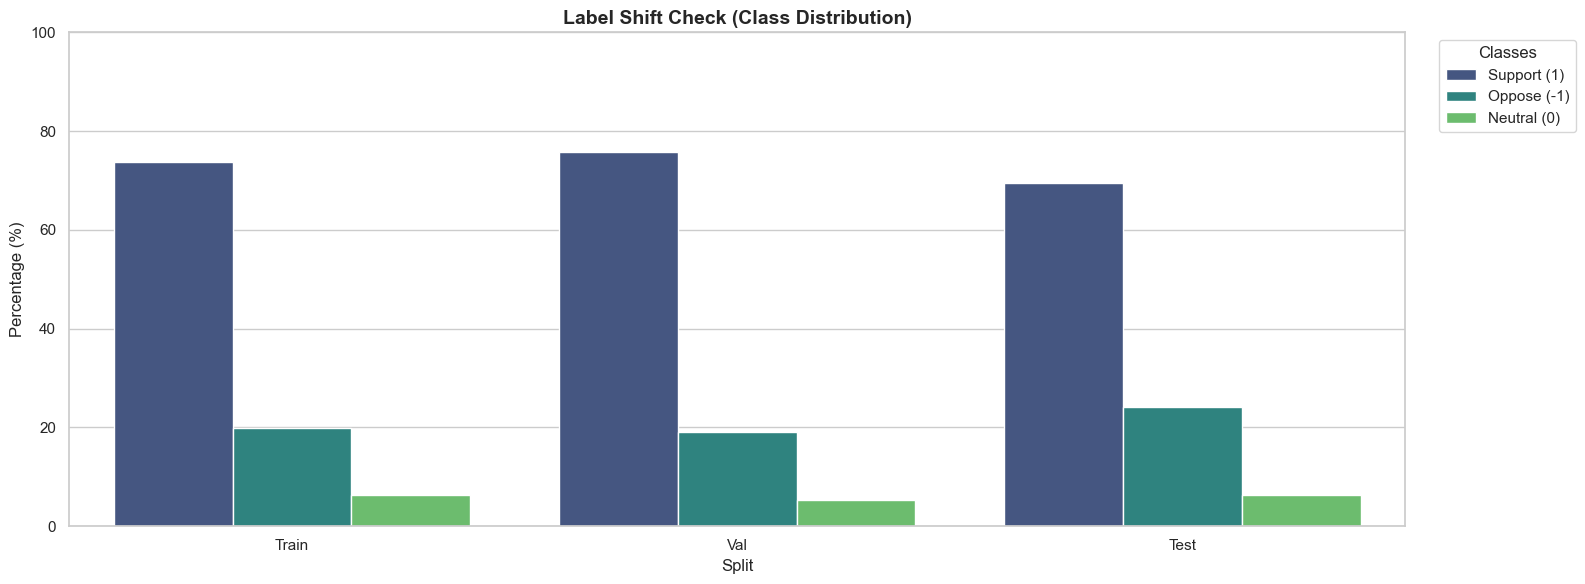

Epoch 00 | Loss(avg): 1.1020 | Val macro-F1(4): 0.3448 | Val link-F1: 0.6341 | Val pol-macroF1: 0.2735
Epoch 01 | Loss(avg): 1.0830 | Val macro-F1(4): 0.3427 | Val link-F1: 0.6423 | Val pol-macroF1: 0.2639
Epoch 02 | Loss(avg): 1.0665 | Val macro-F1(4): 0.3274 | Val link-F1: 0.6170 | Val pol-macroF1: 0.2424
Epoch 03 | Loss(avg): 1.0563 | Val macro-F1(4): 0.3293 | Val link-F1: 0.6372 | Val pol-macroF1: 0.2372
Epoch 04 | Loss(avg): 1.0486 | Val macro-F1(4): 0.3251 | Val link-F1: 0.6351 | Val pol-macroF1: 0.2277
Epoch 05 | Loss(avg): 1.0399 | Val macro-F1(4): 0.3206 | Val link-F1: 0.6300 | Val pol-macroF1: 0.2203
Early stopping. Best Val macro-F1(4): 0.3448
Test macro-F1(4-class): 0.2735
Test link-F1 (existence): 0.4034
Test polarity macro-F1 on TP edges: 0.2147

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.72      0.93      0.81     32286
      Oppose       0.16      0.23      0.19      3895
   

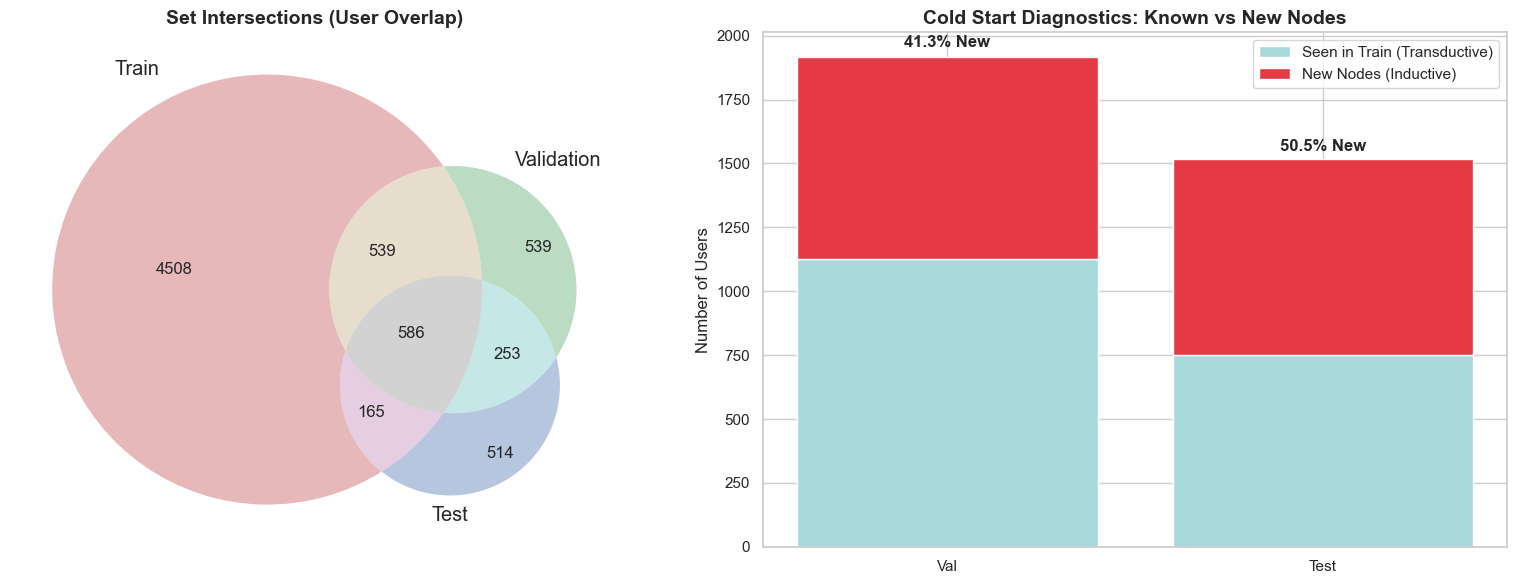


[3] Edge Duplicates Analysis
Found 590 duplicate edges between Train-Val
Found 84 duplicate edges between Train-Test
Found 251 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


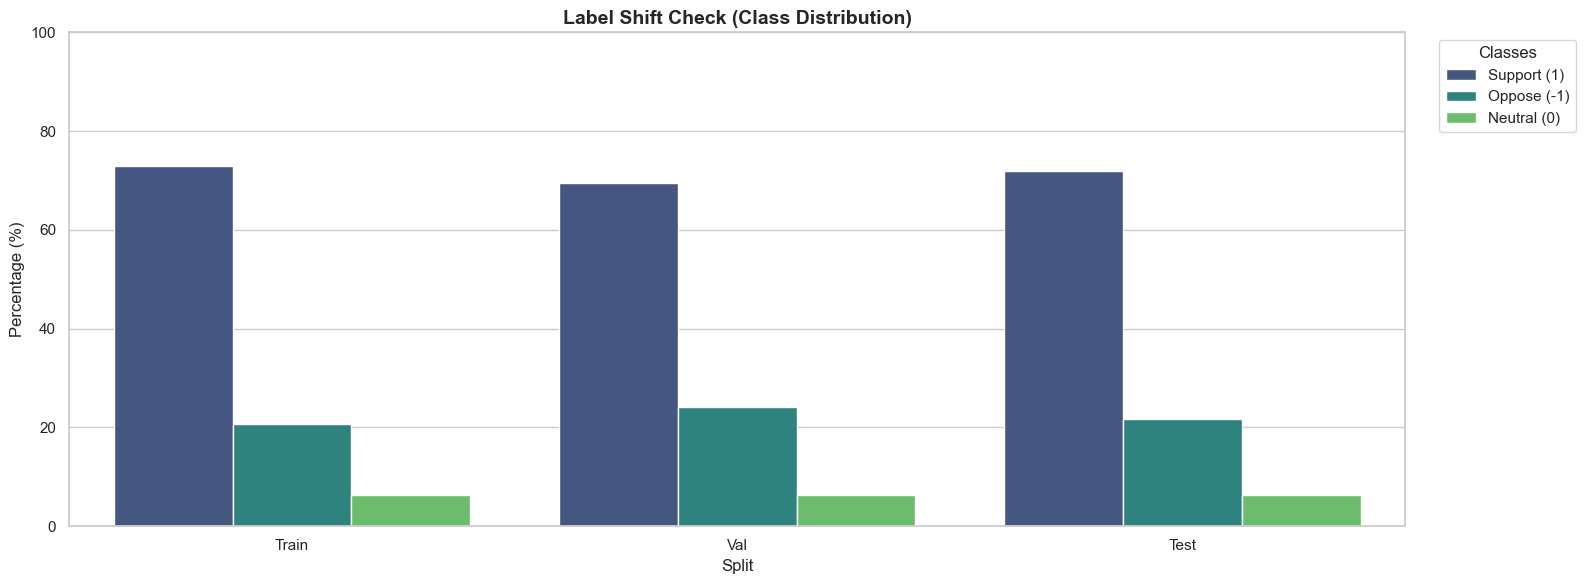

Epoch 00 | Loss(avg): 1.1172 | Val macro-F1(4): 0.3534 | Val link-F1: 0.6516 | Val pol-macroF1: 0.2808
Epoch 01 | Loss(avg): 1.0968 | Val macro-F1(4): 0.3551 | Val link-F1: 0.6417 | Val pol-macroF1: 0.2885
Epoch 02 | Loss(avg): 1.0832 | Val macro-F1(4): 0.3466 | Val link-F1: 0.6374 | Val pol-macroF1: 0.2724
Epoch 03 | Loss(avg): 1.0738 | Val macro-F1(4): 0.3426 | Val link-F1: 0.6263 | Val pol-macroF1: 0.2683
Epoch 04 | Loss(avg): 1.0628 | Val macro-F1(4): 0.3545 | Val link-F1: 0.6371 | Val pol-macroF1: 0.2892
Epoch 05 | Loss(avg): 1.0590 | Val macro-F1(4): 0.3415 | Val link-F1: 0.6267 | Val pol-macroF1: 0.2665
Epoch 06 | Loss(avg): 1.0449 | Val macro-F1(4): 0.3344 | Val link-F1: 0.6260 | Val pol-macroF1: 0.2533
Early stopping. Best Val macro-F1(4): 0.3551
Test macro-F1(4-class): 0.2905
Test link-F1 (existence): 0.4681
Test polarity macro-F1 on TP edges: 0.2292

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      No

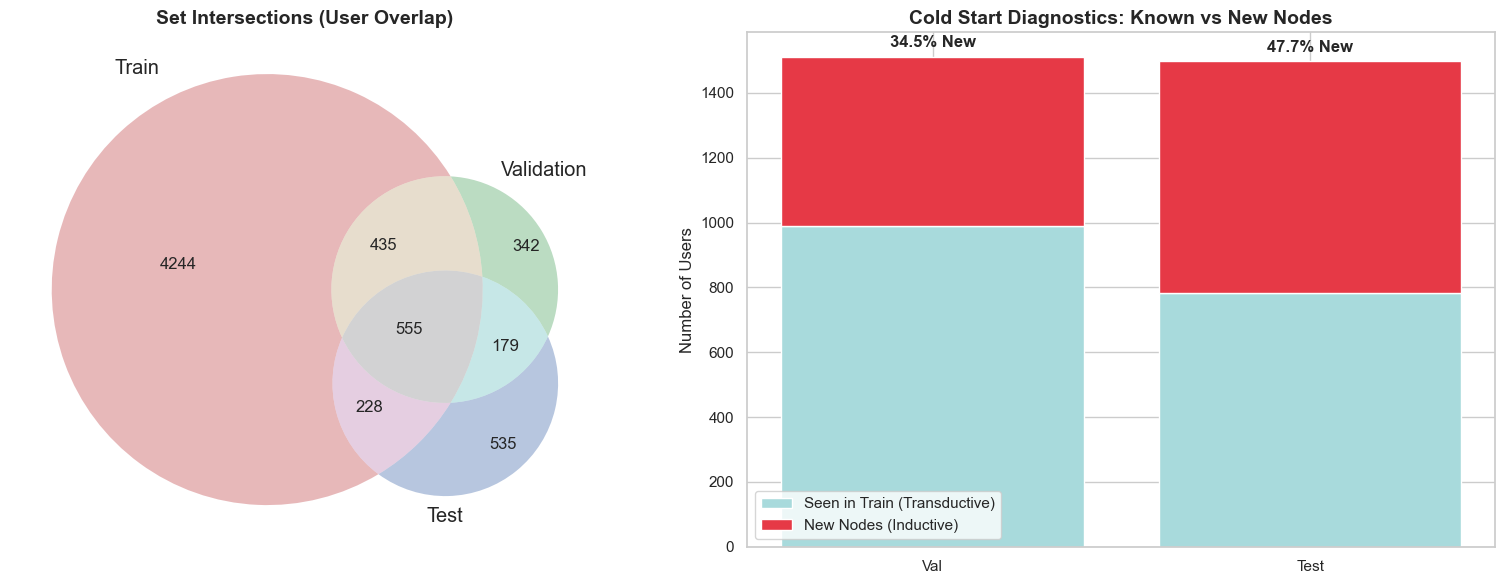


[3] Edge Duplicates Analysis
Found 322 duplicate edges between Train-Val
Found 219 duplicate edges between Train-Test
Found 377 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


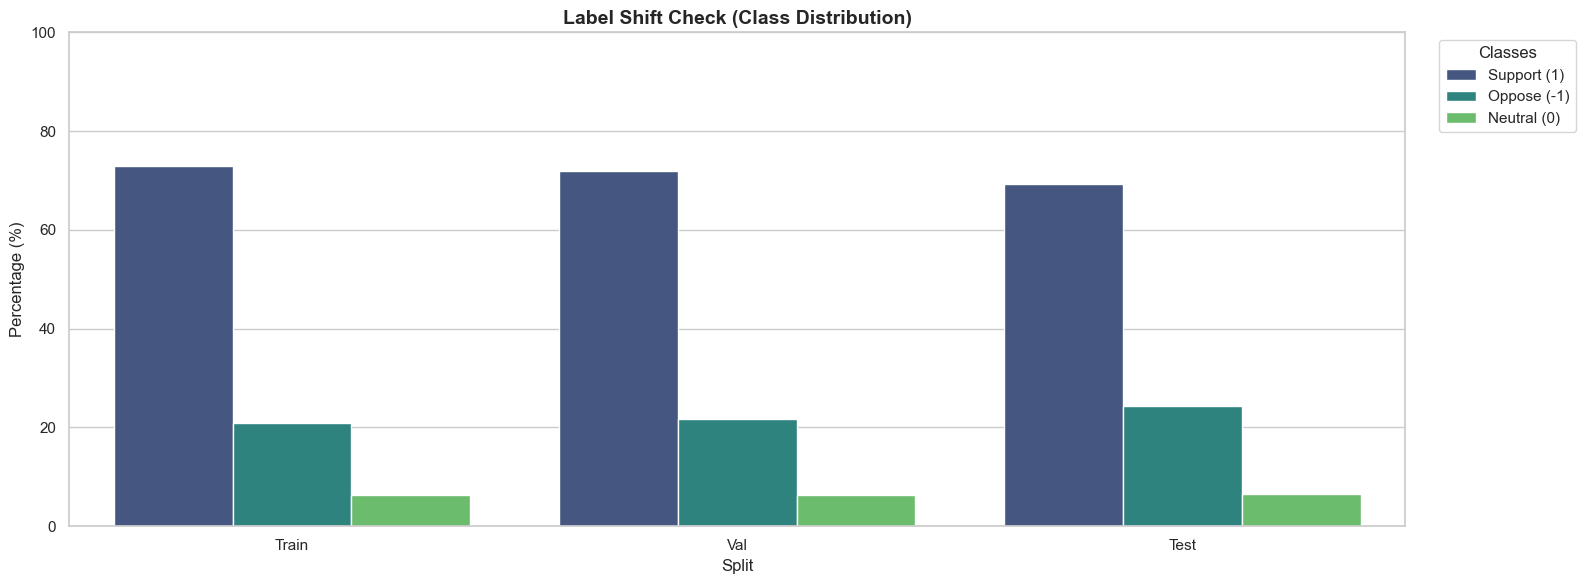

Epoch 00 | Loss(avg): 1.1026 | Val macro-F1(4): 0.3549 | Val link-F1: 0.6766 | Val pol-macroF1: 0.2669
Epoch 01 | Loss(avg): 1.0878 | Val macro-F1(4): 0.3573 | Val link-F1: 0.6807 | Val pol-macroF1: 0.2725
Epoch 02 | Loss(avg): 1.0780 | Val macro-F1(4): 0.3448 | Val link-F1: 0.6539 | Val pol-macroF1: 0.2581
Epoch 03 | Loss(avg): 1.0655 | Val macro-F1(4): 0.3499 | Val link-F1: 0.6727 | Val pol-macroF1: 0.2628
Epoch 04 | Loss(avg): 1.0608 | Val macro-F1(4): 0.3480 | Val link-F1: 0.6653 | Val pol-macroF1: 0.2612
Epoch 05 | Loss(avg): 1.0528 | Val macro-F1(4): 0.3413 | Val link-F1: 0.6704 | Val pol-macroF1: 0.2462
Epoch 06 | Loss(avg): 1.0446 | Val macro-F1(4): 0.3433 | Val link-F1: 0.6512 | Val pol-macroF1: 0.2577
Early stopping. Best Val macro-F1(4): 0.3573
Test macro-F1(4-class): 0.3000
Test link-F1 (existence): 0.5230
Test polarity macro-F1 on TP edges: 0.2210

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      No

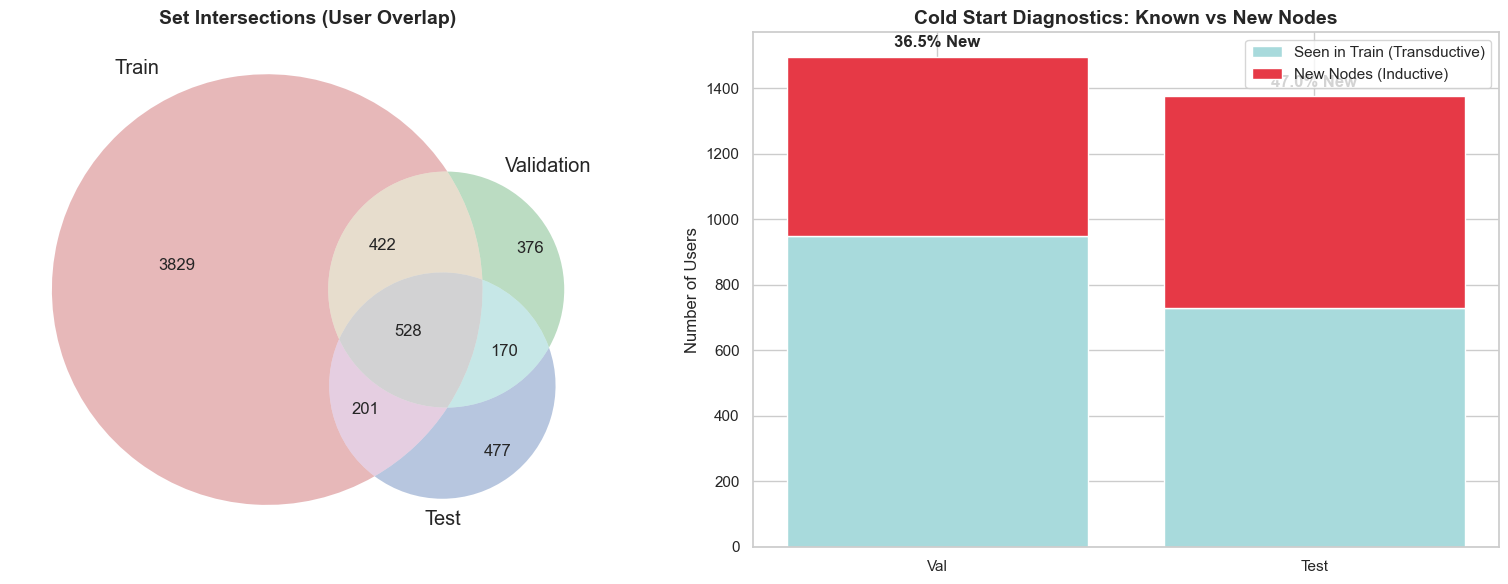


[3] Edge Duplicates Analysis
Found 552 duplicate edges between Train-Val
Found 248 duplicate edges between Train-Test
Found 443 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


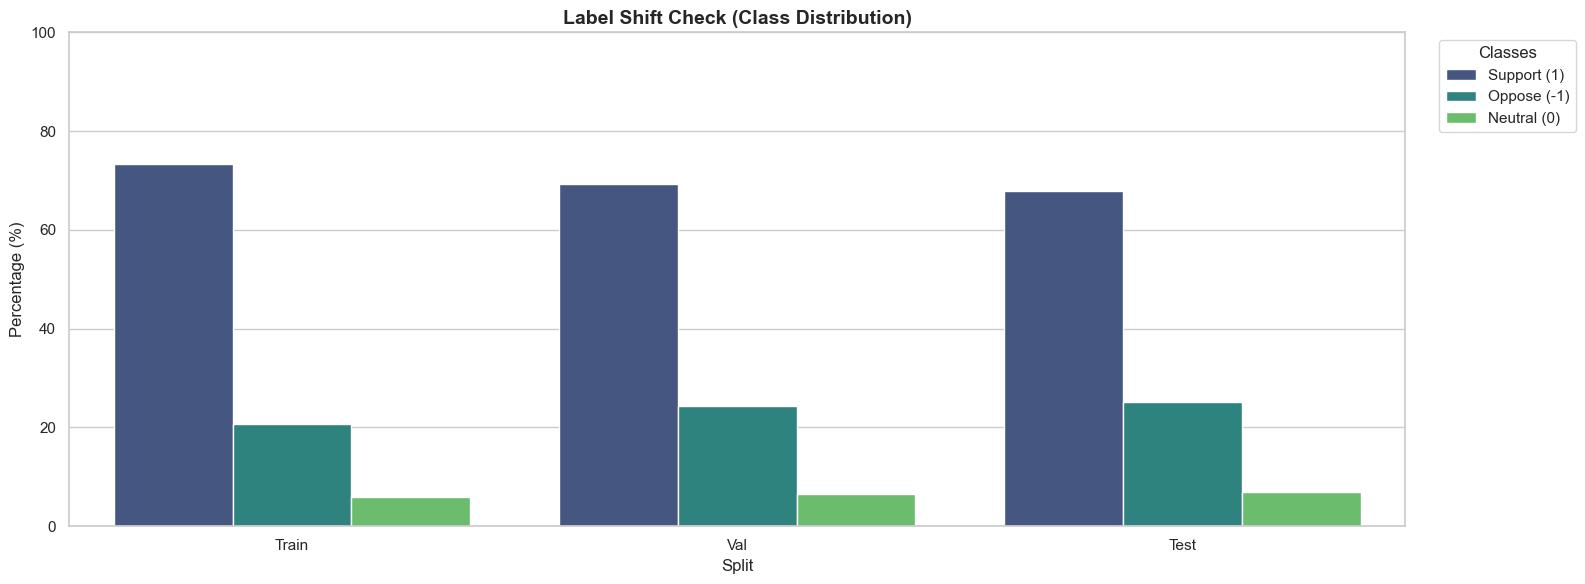

Epoch 00 | Loss(avg): 1.0828 | Val macro-F1(4): 0.3561 | Val link-F1: 0.6484 | Val pol-macroF1: 0.2851
Epoch 01 | Loss(avg): 1.0746 | Val macro-F1(4): 0.3587 | Val link-F1: 0.6523 | Val pol-macroF1: 0.2888
Epoch 02 | Loss(avg): 1.0664 | Val macro-F1(4): 0.3610 | Val link-F1: 0.6444 | Val pol-macroF1: 0.2987
Epoch 03 | Loss(avg): 1.0565 | Val macro-F1(4): 0.3631 | Val link-F1: 0.6481 | Val pol-macroF1: 0.3012
Epoch 04 | Loss(avg): 1.0494 | Val macro-F1(4): 0.3590 | Val link-F1: 0.6430 | Val pol-macroF1: 0.2939
Epoch 05 | Loss(avg): 1.0432 | Val macro-F1(4): 0.3626 | Val link-F1: 0.6401 | Val pol-macroF1: 0.3038
Epoch 06 | Loss(avg): 1.0371 | Val macro-F1(4): 0.3604 | Val link-F1: 0.6484 | Val pol-macroF1: 0.2966
Epoch 07 | Loss(avg): 1.0342 | Val macro-F1(4): 0.3597 | Val link-F1: 0.6445 | Val pol-macroF1: 0.2965
Epoch 08 | Loss(avg): 1.0310 | Val macro-F1(4): 0.3616 | Val link-F1: 0.6477 | Val pol-macroF1: 0.2985
Early stopping. Best Val macro-F1(4): 0.3631
Test macro-F1(4-class): 0.31

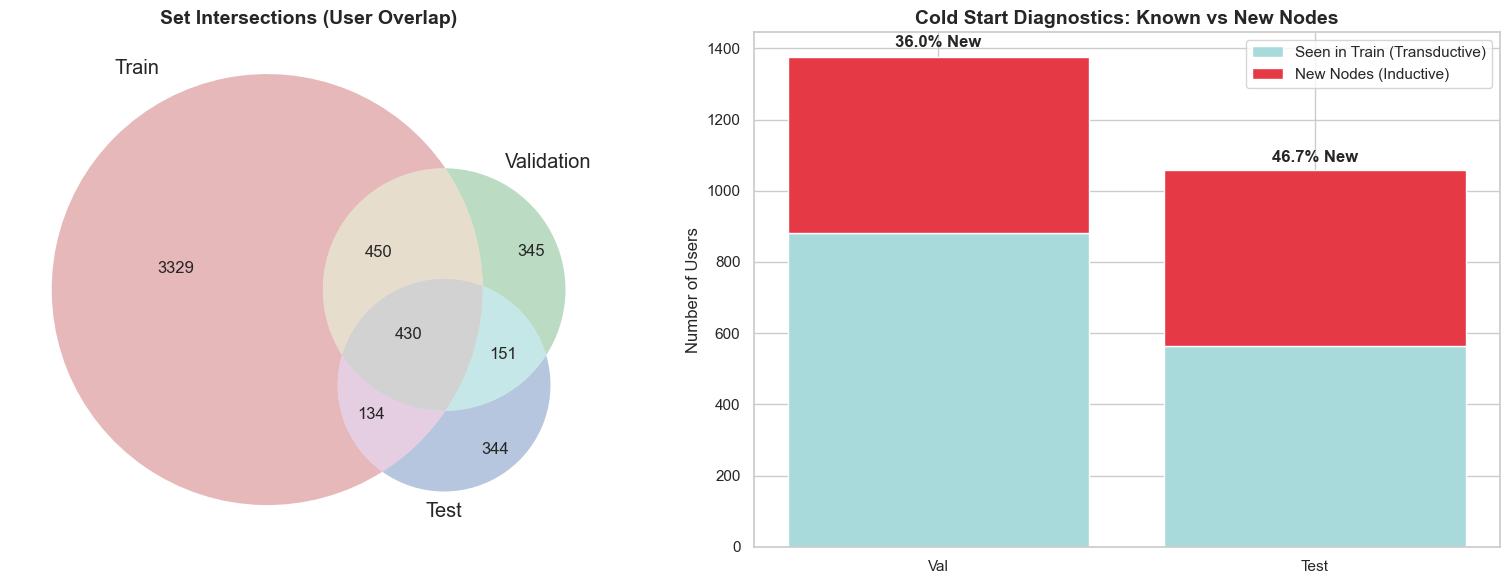


[3] Edge Duplicates Analysis
Found 606 duplicate edges between Train-Val
Found 167 duplicate edges between Train-Test
Found 197 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


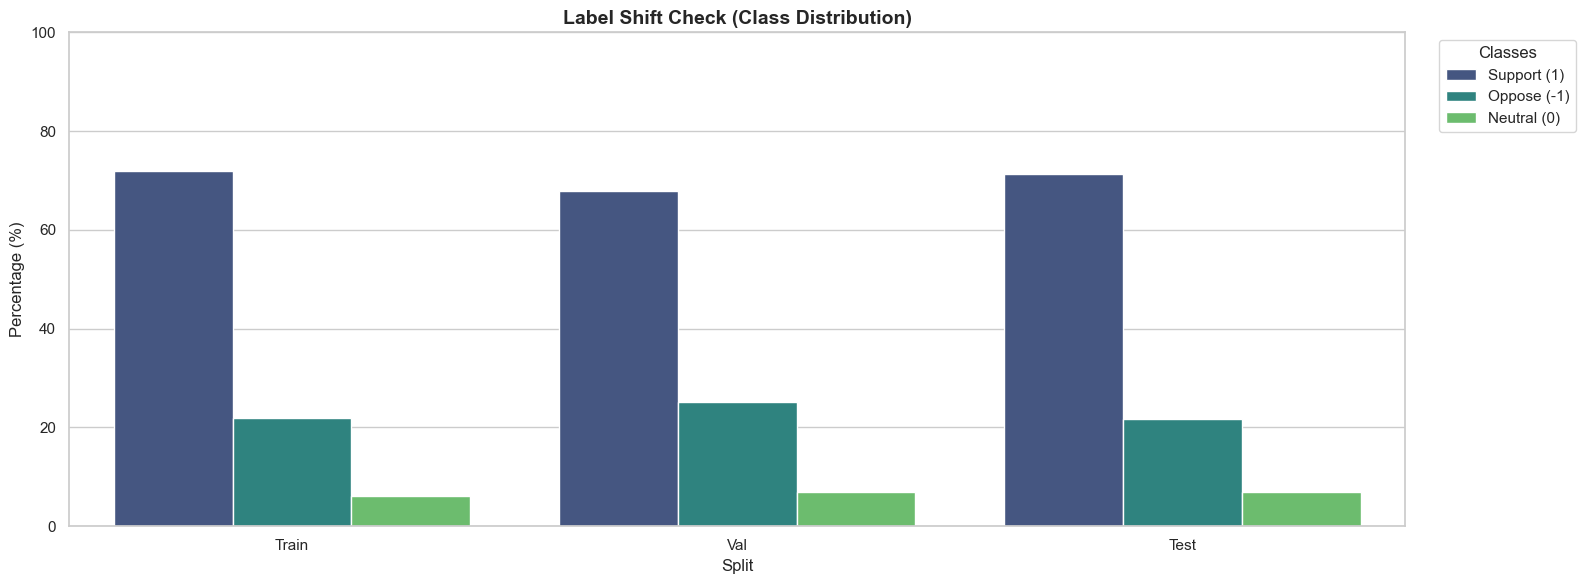

Epoch 00 | Loss(avg): 1.0851 | Val macro-F1(4): 0.3899 | Val link-F1: 0.6846 | Val pol-macroF1: 0.3312
Epoch 01 | Loss(avg): 1.0720 | Val macro-F1(4): 0.3876 | Val link-F1: 0.6745 | Val pol-macroF1: 0.3303
Epoch 02 | Loss(avg): 1.0645 | Val macro-F1(4): 0.3824 | Val link-F1: 0.6839 | Val pol-macroF1: 0.3153
Epoch 03 | Loss(avg): 1.0587 | Val macro-F1(4): 0.3814 | Val link-F1: 0.6977 | Val pol-macroF1: 0.3083
Epoch 04 | Loss(avg): 1.0546 | Val macro-F1(4): 0.3746 | Val link-F1: 0.6871 | Val pol-macroF1: 0.3015
Epoch 05 | Loss(avg): 1.0529 | Val macro-F1(4): 0.3711 | Val link-F1: 0.6934 | Val pol-macroF1: 0.2900
Early stopping. Best Val macro-F1(4): 0.3899


c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3121
Test link-F1 (existence): 0.5231
Test polarity macro-F1 on TP edges: 0.2536

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.76      0.93      0.84     12640
      Oppose       0.18      0.34      0.23      1371
     Neutral       0.00      0.00      0.00       438
     Support       0.60      0.11      0.18      4511

    accuracy                           0.67     18960
   macro avg       0.38      0.34      0.31     18960
weighted avg       0.66      0.67      0.62     18960


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.24      0.85      0.37       547
     Neutral       0.00      0.00      0.00       132
     Support       0.83      0.26      0.39      1867

    accuracy                           0.37      2546
   macro avg       0.36      0.37      0.25      

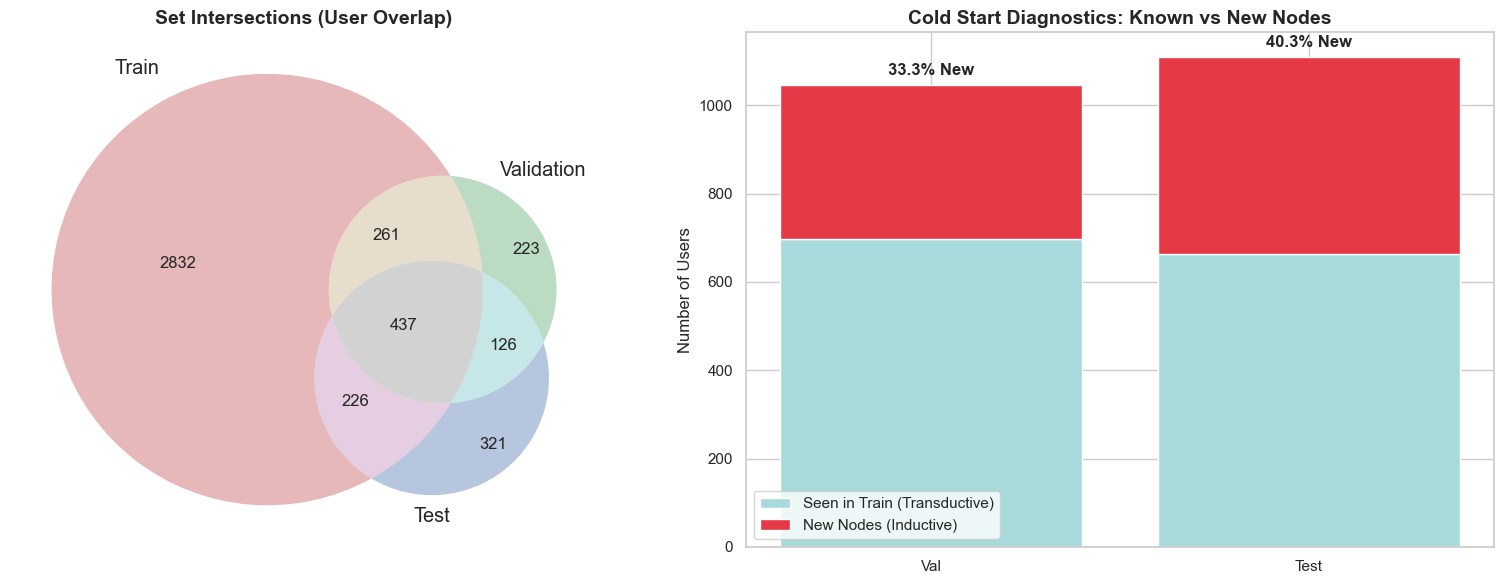


[3] Edge Duplicates Analysis
Found 324 duplicate edges between Train-Val
Found 203 duplicate edges between Train-Test
Found 157 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


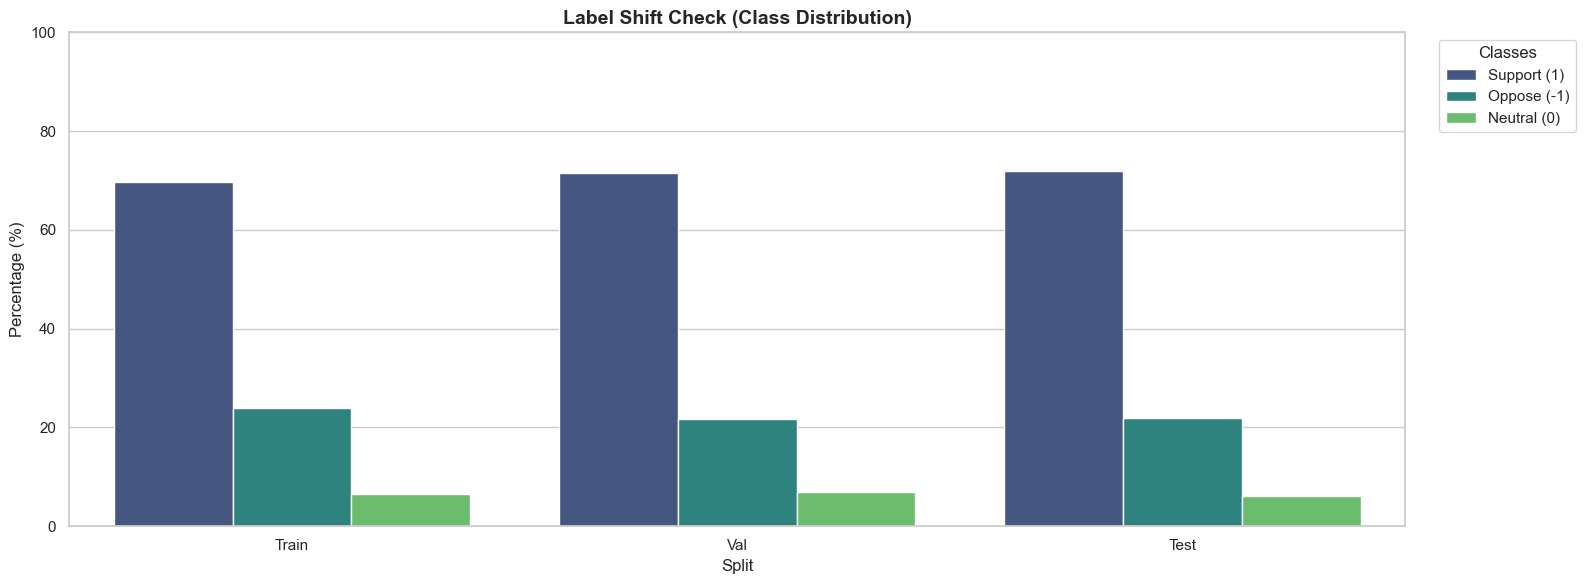

Epoch 00 | Loss(avg): 1.1002 | Val macro-F1(4): 0.3967 | Val link-F1: 0.6648 | Val pol-macroF1: 0.3527
Epoch 01 | Loss(avg): 1.0855 | Val macro-F1(4): 0.3950 | Val link-F1: 0.6798 | Val pol-macroF1: 0.3396
Epoch 02 | Loss(avg): 1.0767 | Val macro-F1(4): 0.3958 | Val link-F1: 0.6758 | Val pol-macroF1: 0.3446
Epoch 03 | Loss(avg): 1.0799 | Val macro-F1(4): 0.3974 | Val link-F1: 0.6764 | Val pol-macroF1: 0.3507
Epoch 04 | Loss(avg): 1.0683 | Val macro-F1(4): 0.3833 | Val link-F1: 0.6632 | Val pol-macroF1: 0.3285
Epoch 05 | Loss(avg): 1.0594 | Val macro-F1(4): 0.3854 | Val link-F1: 0.6712 | Val pol-macroF1: 0.3264
Epoch 06 | Loss(avg): 1.0621 | Val macro-F1(4): 0.3772 | Val link-F1: 0.6767 | Val pol-macroF1: 0.3097
Epoch 07 | Loss(avg): 1.0563 | Val macro-F1(4): 0.3795 | Val link-F1: 0.6537 | Val pol-macroF1: 0.3263
Epoch 08 | Loss(avg): 1.0492 | Val macro-F1(4): 0.3927 | Val link-F1: 0.6857 | Val pol-macroF1: 0.3364
Early stopping. Best Val macro-F1(4): 0.3974
Test macro-F1(4-class): 0.32

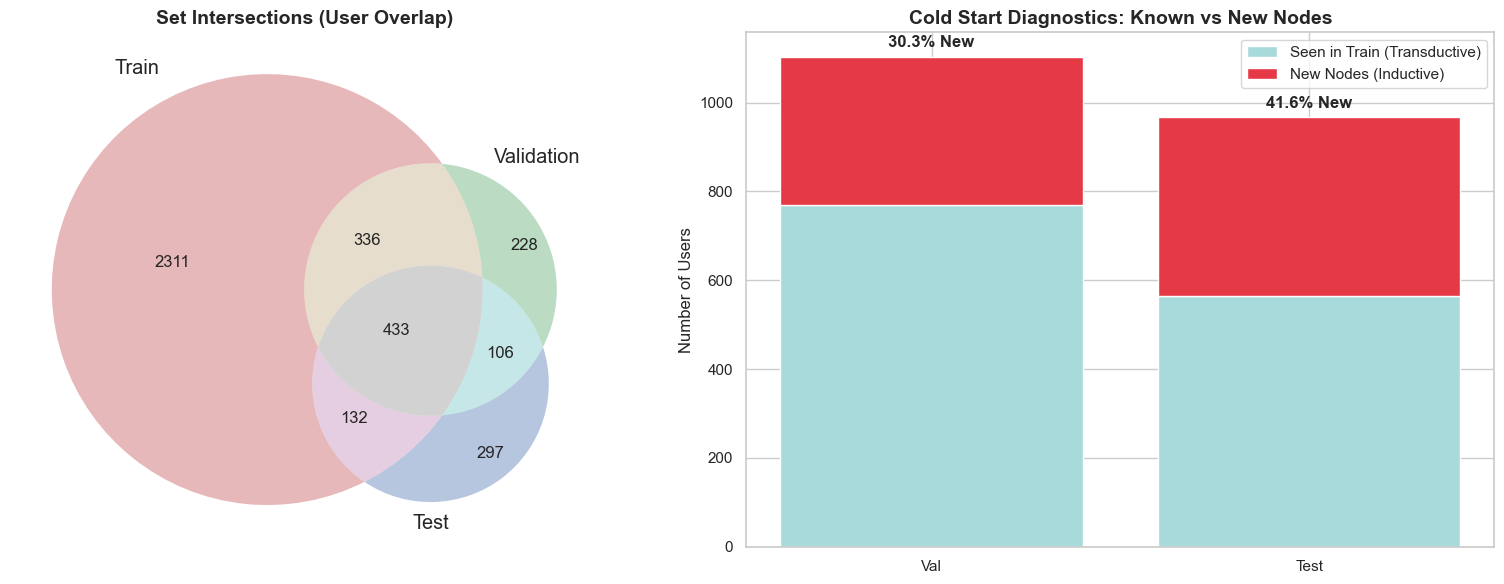


[3] Edge Duplicates Analysis
Found 339 duplicate edges between Train-Val
Found 103 duplicate edges between Train-Test
Found 62 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


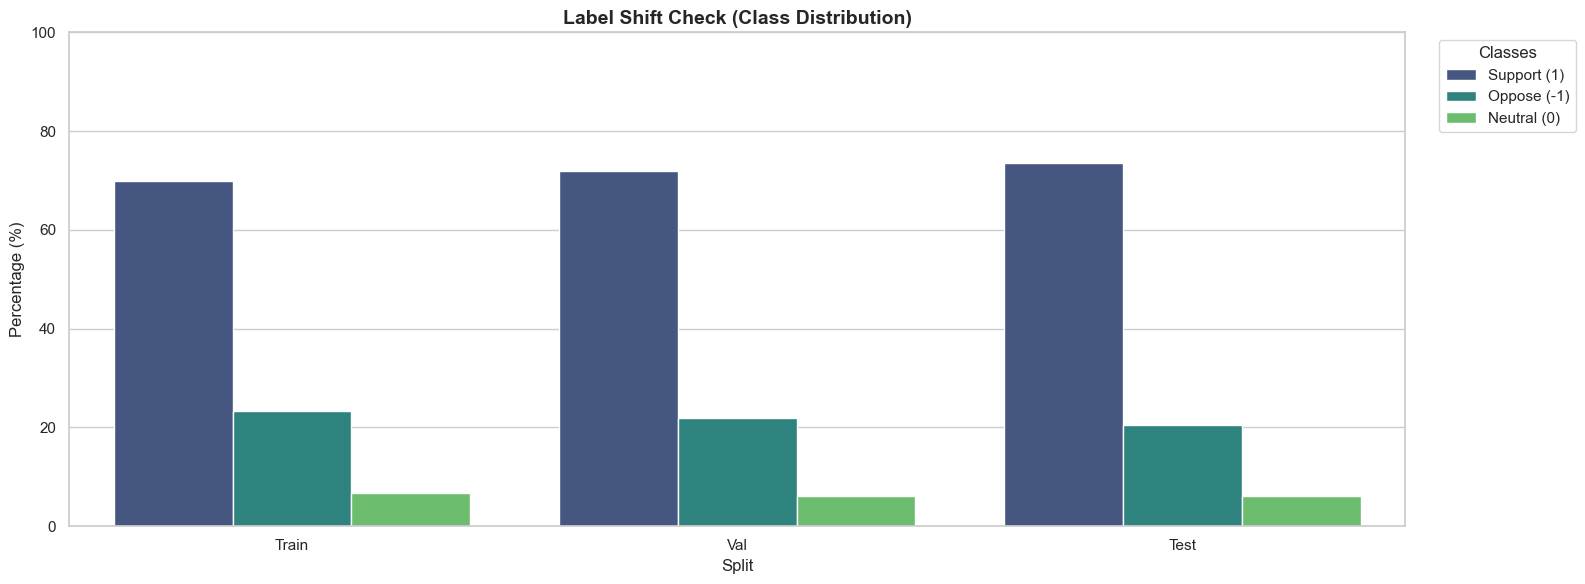

Epoch 00 | Loss(avg): 1.0770 | Val macro-F1(4): 0.4139 | Val link-F1: 0.7367 | Val pol-macroF1: 0.3455
Epoch 01 | Loss(avg): 1.0592 | Val macro-F1(4): 0.4143 | Val link-F1: 0.7276 | Val pol-macroF1: 0.3506
Epoch 02 | Loss(avg): 1.0555 | Val macro-F1(4): 0.4114 | Val link-F1: 0.7119 | Val pol-macroF1: 0.3547
Epoch 03 | Loss(avg): 1.0476 | Val macro-F1(4): 0.4129 | Val link-F1: 0.7155 | Val pol-macroF1: 0.3557
Epoch 04 | Loss(avg): 1.0421 | Val macro-F1(4): 0.4117 | Val link-F1: 0.7166 | Val pol-macroF1: 0.3527
Epoch 05 | Loss(avg): 1.0362 | Val macro-F1(4): 0.4061 | Val link-F1: 0.7256 | Val pol-macroF1: 0.3379
Epoch 06 | Loss(avg): 1.0339 | Val macro-F1(4): 0.4074 | Val link-F1: 0.7357 | Val pol-macroF1: 0.3339
Early stopping. Best Val macro-F1(4): 0.4143


c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3465
Test link-F1 (existence): 0.6343
Test polarity macro-F1 on TP edges: 0.2696

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.80      0.95      0.86     10040
      Oppose       0.19      0.39      0.26      1028
     Neutral       0.00      0.00      0.00       303
     Support       0.63      0.17      0.27      3689

    accuracy                           0.70     15060
   macro avg       0.40      0.38      0.35     15060
weighted avg       0.70      0.70      0.66     15060


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.23      0.76      0.35       535
     Neutral       0.00      0.00      0.00       145
     Support       0.78      0.33      0.46      1901

    accuracy                           0.40      2581
   macro avg       0.34      0.36      0.27      

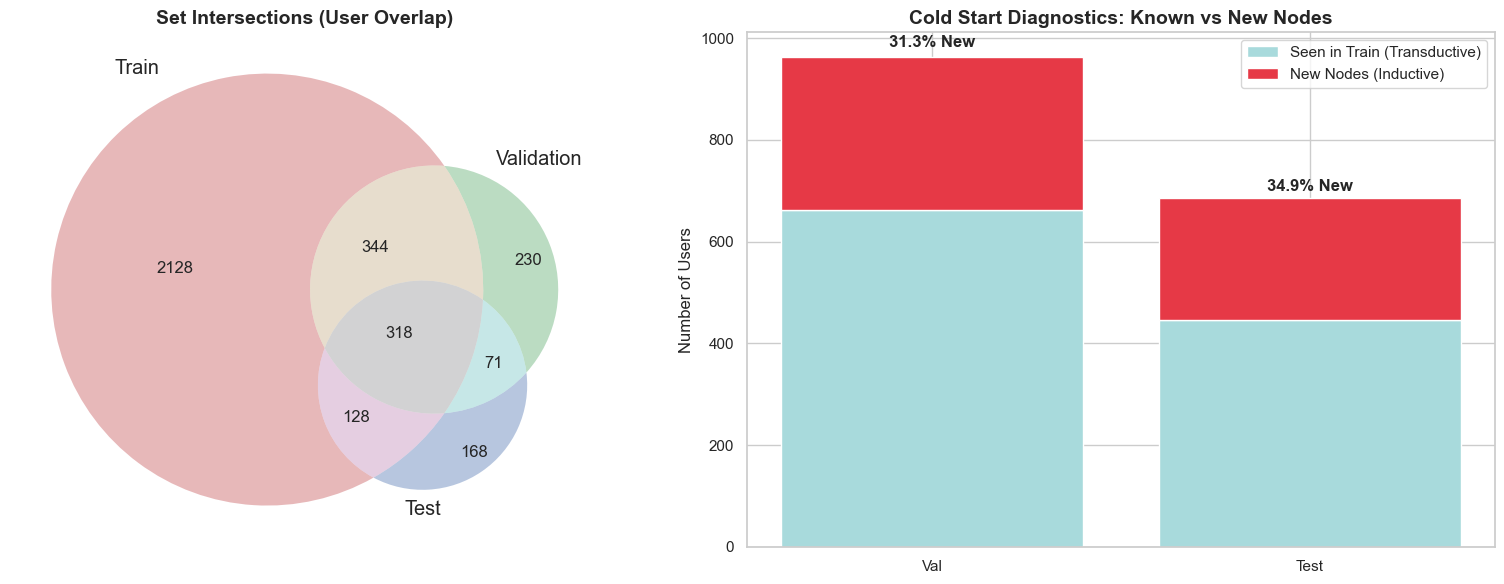


[3] Edge Duplicates Analysis
Found 165 duplicate edges between Train-Val
Found 73 duplicate edges between Train-Test
Found 24 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


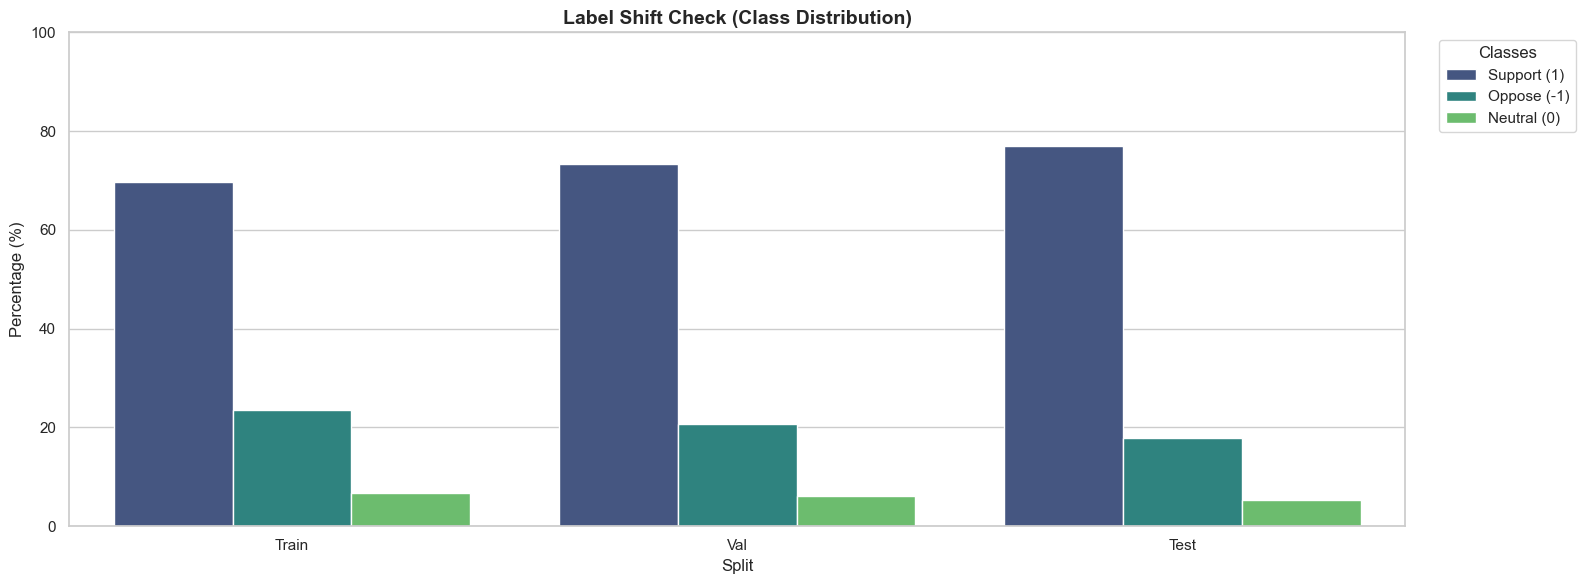

Epoch 00 | Loss(avg): 1.0737 | Val macro-F1(4): 0.4000 | Val link-F1: 0.7419 | Val pol-macroF1: 0.3143
Epoch 01 | Loss(avg): 1.0510 | Val macro-F1(4): 0.3984 | Val link-F1: 0.7455 | Val pol-macroF1: 0.3099
Epoch 02 | Loss(avg): 1.0427 | Val macro-F1(4): 0.4000 | Val link-F1: 0.7558 | Val pol-macroF1: 0.3079
Epoch 03 | Loss(avg): 1.0395 | Val macro-F1(4): 0.4007 | Val link-F1: 0.7463 | Val pol-macroF1: 0.3132
Epoch 04 | Loss(avg): 1.0315 | Val macro-F1(4): 0.4148 | Val link-F1: 0.7541 | Val pol-macroF1: 0.3343
Epoch 05 | Loss(avg): 1.0260 | Val macro-F1(4): 0.3951 | Val link-F1: 0.7369 | Val pol-macroF1: 0.3084
Epoch 06 | Loss(avg): 1.0235 | Val macro-F1(4): 0.4104 | Val link-F1: 0.7504 | Val pol-macroF1: 0.3285
Epoch 07 | Loss(avg): 1.0284 | Val macro-F1(4): 0.4023 | Val link-F1: 0.7419 | Val pol-macroF1: 0.3183
Epoch 08 | Loss(avg): 1.0164 | Val macro-F1(4): 0.4226 | Val link-F1: 0.7410 | Val pol-macroF1: 0.3570
Epoch 09 | Loss(avg): 1.0130 | Val macro-F1(4): 0.4289 | Val link-F1: 0.7

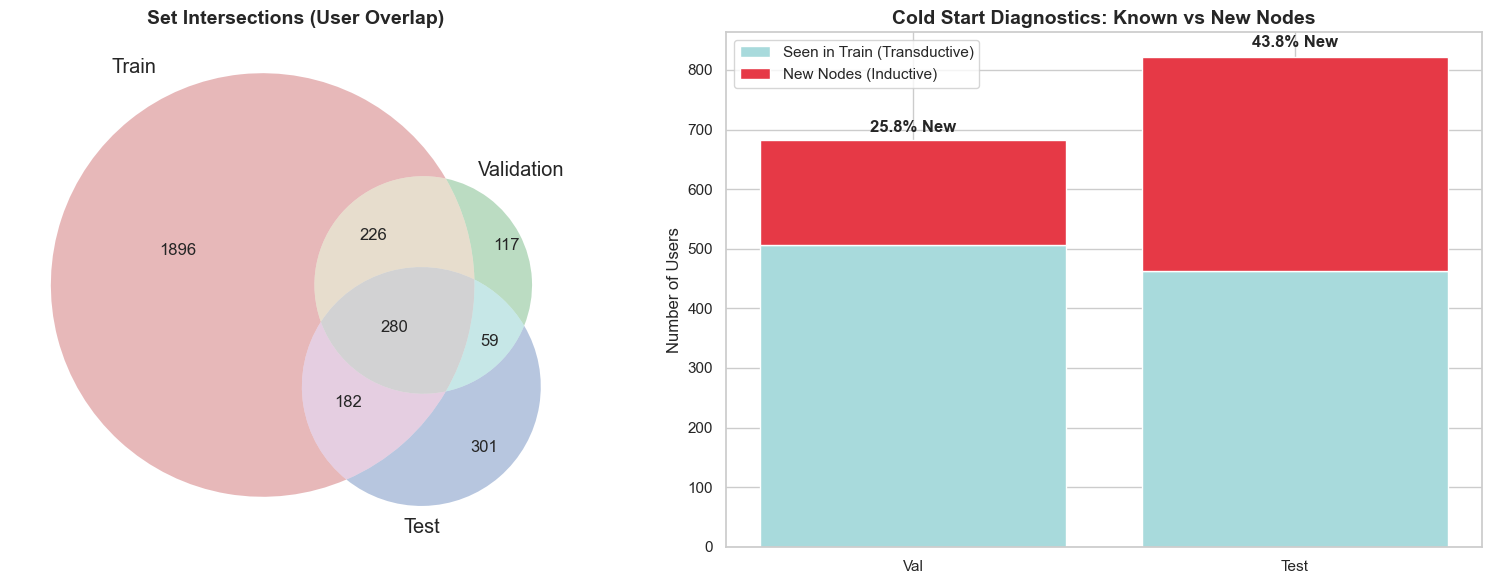


[3] Edge Duplicates Analysis
Found 92 duplicate edges between Train-Val
Found 15 duplicate edges between Train-Test
Found 9 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


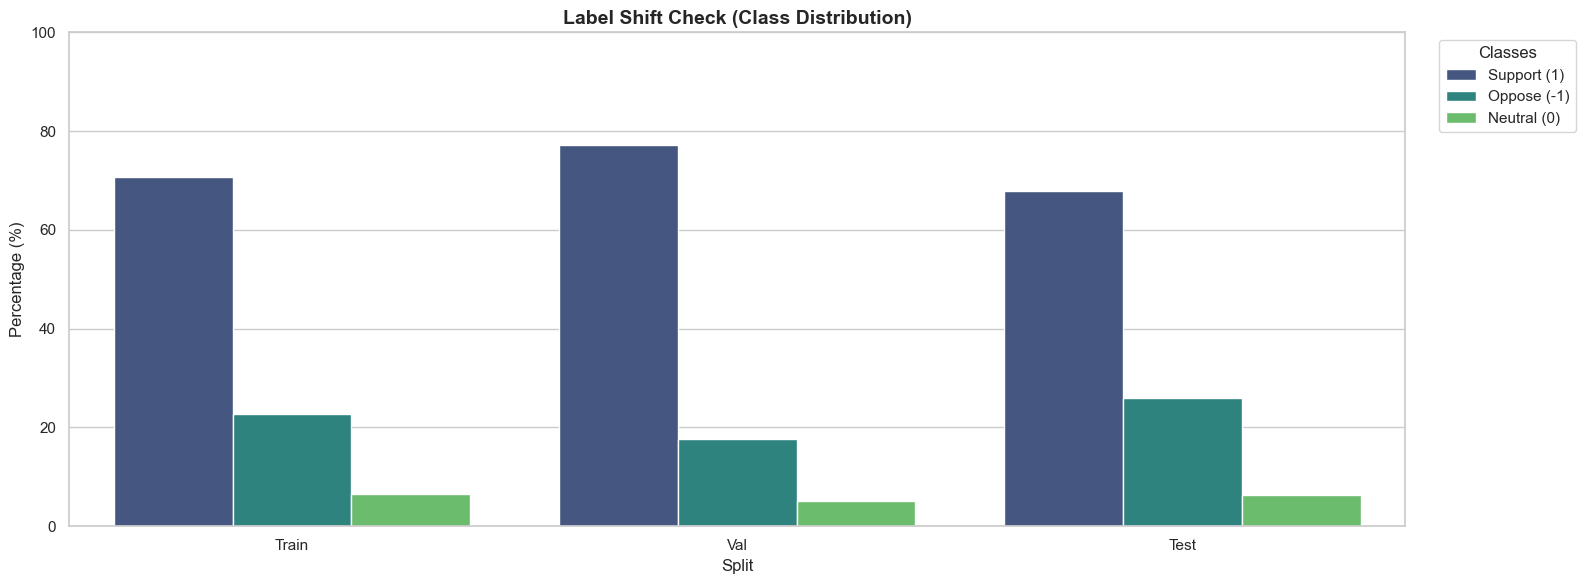

Epoch 00 | Loss(avg): 1.0402 | Val macro-F1(4): 0.4335 | Val link-F1: 0.7339 | Val pol-macroF1: 0.3781
Epoch 01 | Loss(avg): 1.0120 | Val macro-F1(4): 0.4293 | Val link-F1: 0.7462 | Val pol-macroF1: 0.3651
Epoch 02 | Loss(avg): 1.0088 | Val macro-F1(4): 0.4255 | Val link-F1: 0.7474 | Val pol-macroF1: 0.3568
Epoch 03 | Loss(avg): 0.9970 | Val macro-F1(4): 0.4228 | Val link-F1: 0.7485 | Val pol-macroF1: 0.3521
Epoch 04 | Loss(avg): 0.9895 | Val macro-F1(4): 0.4312 | Val link-F1: 0.7488 | Val pol-macroF1: 0.3670
Epoch 05 | Loss(avg): 0.9819 | Val macro-F1(4): 0.3995 | Val link-F1: 0.7405 | Val pol-macroF1: 0.3157
Early stopping. Best Val macro-F1(4): 0.4335
Test macro-F1(4-class): 0.3230
Test link-F1 (existence): 0.5631
Test polarity macro-F1 on TP edges: 0.2484

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.77      0.96      0.85      7574
      Oppose       0.23      0.33      0.27       983
   

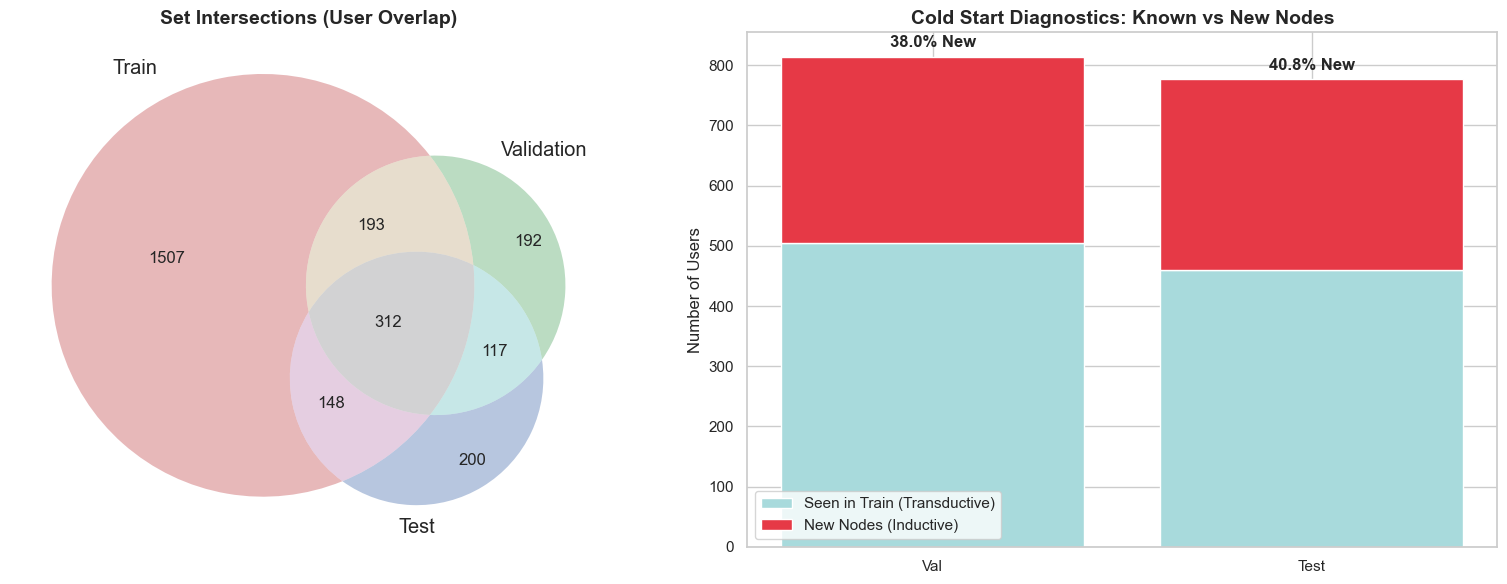


[3] Edge Duplicates Analysis
Found 23 duplicate edges between Train-Val
Found 17 duplicate edges between Train-Test
Found 72 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


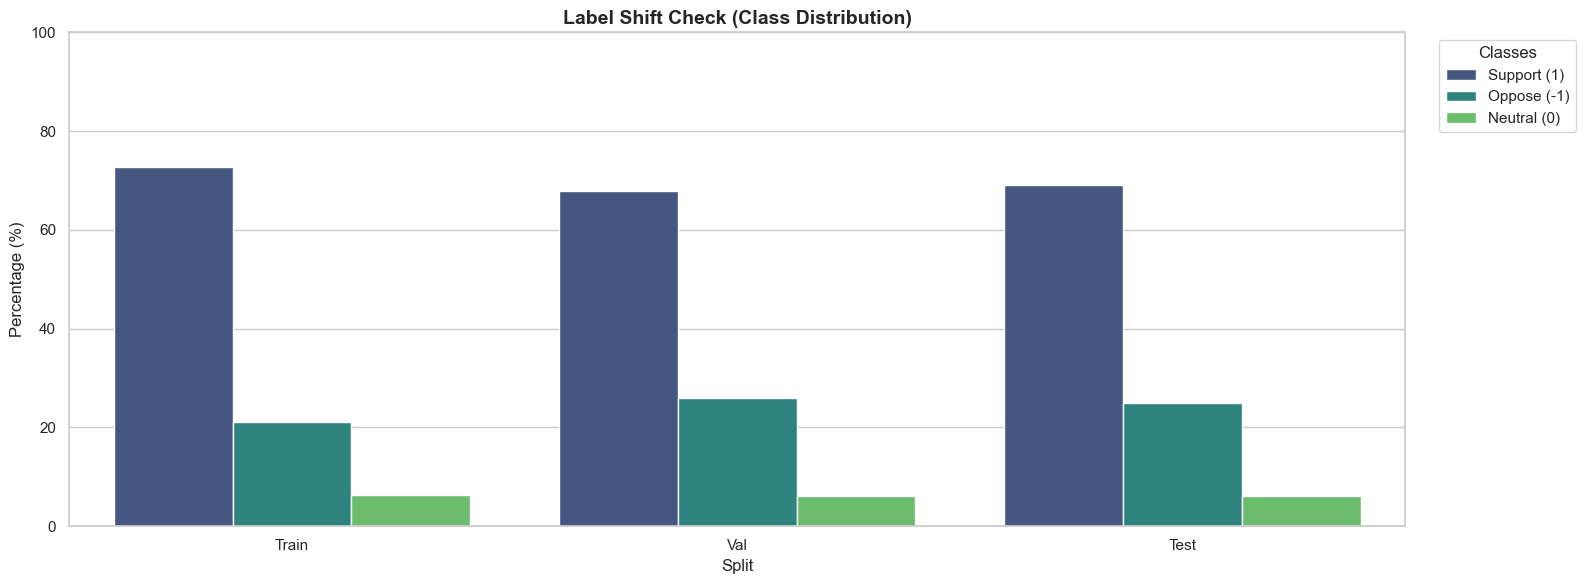

Epoch 00 | Loss(avg): 1.0001 | Val macro-F1(4): 0.3807 | Val link-F1: 0.6499 | Val pol-macroF1: 0.3278
Epoch 01 | Loss(avg): 0.9786 | Val macro-F1(4): 0.3853 | Val link-F1: 0.6545 | Val pol-macroF1: 0.3349
Epoch 02 | Loss(avg): 0.9720 | Val macro-F1(4): 0.3829 | Val link-F1: 0.6522 | Val pol-macroF1: 0.3306
Epoch 03 | Loss(avg): 0.9638 | Val macro-F1(4): 0.3752 | Val link-F1: 0.6454 | Val pol-macroF1: 0.3183
Epoch 04 | Loss(avg): 0.9581 | Val macro-F1(4): 0.3686 | Val link-F1: 0.6610 | Val pol-macroF1: 0.2979
Epoch 05 | Loss(avg): 0.9552 | Val macro-F1(4): 0.3606 | Val link-F1: 0.6433 | Val pol-macroF1: 0.2938
Epoch 06 | Loss(avg): 0.9451 | Val macro-F1(4): 0.3718 | Val link-F1: 0.6570 | Val pol-macroF1: 0.3074
Early stopping. Best Val macro-F1(4): 0.3853
Test macro-F1(4-class): 0.3098
Test link-F1 (existence): 0.5605
Test polarity macro-F1 on TP edges: 0.2258

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      No

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # oppure 'mps' su Mac
num_users = len(user_map)

model = HierGNN(feature_dim=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

link_weights = torch.tensor([0.85, 1.22], dtype=torch.float).to(device)  # Example weights
pol_weights = torch.tensor([1.25, 2.32, 0.67], dtype=torch.float).to(device)  # Example weights


for i, ((X_tr, y_tr, dates_tr), (X_va, y_va, dates_va), (X_te, y_te, dates_te)) in enumerate(get_windows(X, y_pos, dates)):
    print(f"\n--- Window {i} ---")

    # ---------------------------------------------------------
    # 1. Build the message-passing graph from TRAIN POSITIVE edges only
    # ---------------------------------------------------------
    train_edge_index = X_tr.t().contiguous()  # [2, E_train_pos]

    # Extract node features from training edges
    x_features = extract_node_features(
        edge_index=train_edge_index,
        edge_dates_int=torch.tensor(dates_tr, dtype=torch.long),
        num_nodes=num_users
    )

    data = Data(x=x_features, edge_index=train_edge_index)
    analyze_split_statistics(X_tr, y_tr, X_va, y_va, X_te, y_te)

    # ---------------------------------------------------------
    # 2. Negative sampling
    # ---------------------------------------------------------
    neg_ratio = 2
    sampler = CandidateCentricSampler([X_tr, X_va, X_te])

    # Negatives for each split (no_vote = 0)
    X_tr_neg, y_tr_neg = sampler.sample_negatives(X_tr, num_users, ratio=neg_ratio, seed=42)
    X_val_neg, y_val_neg = sampler.sample_negatives(X_va, num_users, ratio=neg_ratio, seed=123)
    X_test_neg, y_test_neg = sampler.sample_negatives(X_te, num_users, ratio=neg_ratio, seed=999)

    # 4-class datasets: 0=no_vote, 1=oppose, 2=neutral, 3=support
    X_tr_4 = torch.cat([X_tr,  X_tr_neg],  dim=0)
    y_tr_4 = torch.cat([y_tr,  y_tr_neg],  dim=0)

    X_val_4 = torch.cat([X_va, X_val_neg], dim=0)
    y_val_4 = torch.cat([y_va, y_val_neg], dim=0)

    X_test_4 = torch.cat([X_te, X_test_neg], dim=0)
    y_test_4 = torch.cat([y_te, y_test_neg], dim=0)

    # ---------------------------------------------------------
    # 3. Weights per class
    # ---------------------------------------------------------
    # Link labels derived from 4-class labels: 0 -> NoVote, {1,2,3} -> Voted
    y_tr_link = (y_tr_4 != 0).long()
    link_counts = torch.bincount(y_tr_link, minlength=2).float()
    link_base_w = link_counts.sum() / (len(link_counts) * link_counts)
    alpha = 0.5
    link_weights = link_base_w.pow(alpha).to(device)

    # Polarity labels from positives only: {1,2,3} -> {0,1,2}
    y_tr_pol = (y_tr - 1).long()
    pol_counts = torch.bincount(y_tr_pol, minlength=3).float()
    pol_base_w = pol_counts.sum() / (len(pol_counts) * pol_counts)
    pol_weights = pol_base_w.pow(alpha).to(device)

    # ---------------------------------------------------------
    # 4. LinkNeighborLoader
    # ---------------------------------------------------------
    # Message passing happens on data.edge_index (TRAIN POS edges only)
    train_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_tr_4.t().contiguous(),
        edge_label=y_tr_4,
        batch_size=2048,
        shuffle=True
    )

    val_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_val_4.t().contiguous(),
        edge_label=y_val_4,
        batch_size=4096,
        shuffle=False
    )

    test_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_test_4.t().contiguous(),
        edge_label=y_test_4,
        batch_size=4096,
        shuffle=False
    )

    # ---------------------------------------------------------
    # 5. Training loop
    # ---------------------------------------------------------
    best_state = training_loop(
        model, optimizer,
        train_loader, val_loader,
        device,
        link_weights, pol_weights,
        patience=5,
        lambda_pol=1.0,
        num_epochs=50
    )
    model.load_state_dict(best_state)

    # ---------------------------------------------------------
    # 6. Final evaluation on test set
    # ---------------------------------------------------------
    test_macro_f1_4, test_link_f1, test_pol_f1, (y_true_4, y_pred_4), pol_report = eval_hierarchical(model, test_loader, device, report=True)

    print(f"Test macro-F1(4-class): {test_macro_f1_4:.4f}")
    print(f"Test link-F1 (existence): {test_link_f1:.4f}")
    print(f"Test polarity macro-F1 on TP edges: {test_pol_f1:.4f}")
    print("\n4-class Classification Report (NoVote/Oppose/Neutral/Support):")
    print(classification_report(
        y_true_4, y_pred_4,
        target_names=["NoVote", "Oppose", "Neutral", "Support"],
        digits=2
    ))

    print("\nVote polarity report on true-positive links where model predicts Voted:")
    print(pol_report if pol_report is not None else "No TP edges predicted as Voted.")
